# Team: Scammers
# Members: Mayank Kumar, Rishabh Gupta  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Stock Buy/Sell Prediction
In this mini-project - You will be working with real stock data pulled through the alpaca.markets api. We will provide you starter code below - So you can get started with using the API. You have about 2 weeks to work on this mini-project. Please get started early as identifying good strategies can take time. Good luck and have fun in the process!

### Logistics
Please work in groups of 2 - This is a requirement for this project. Your submission will include one submission of all the training code, back testing code, plots, requirements as outlined below + breakdown of contributions by each member of the project. Please make sure each member in your team tries out new trading strategies/algorithms and does coding as a way of contributing to the project. Also working in teams is a great way to brainstorm, collaborate and improve on your winning strategies.

### Question 1
1. Pick any 5 tech stocks that have had a good performance year-over-year in the past year. You can look up NASDAQ tech stocks list or pick your favorites.
1. Download the "closing price" and "opening price" data for each day of the 5 tech stocks over the past year using the ALPACA api (see below for starter code).
1. Train at least 2 baselines (from the lecture - e.g. SMA, EMA) AND one or more ML based models (e.g. STL or supervised learning) on first 7 months of the data set
1. Back-test your buy-sell strategy on the recent past 5 months for each of the 5 stocks you picked. Assume you are not doing day-trading - So you can't sell the stock the same day you bought them. Also assume that you are buying at closing time but can sell at opening or closing time. 
1. Implement your back-testing as an automatic trading mechanism (Algorithmic Trading) - I.e. buy when you have cash available if your algorithm says buy. And sell a bought stock if your algorithm says sell. Make sure, you have a profit margin of at least 0.5%
1. Also implement your back-testing across the 5 stocks - I.e. buy/sell which ever stock is more appealing to your algorithm/trading strategy.
1. Once you initiate the back-test - Your algorithm should be able to automatically buy and sell multiple times across the back-testing period (5 months). This is an example of Algorithmic trading - Where you don't have to initiate buy/sell order but the algorithm would do it for you. Avoid a buy-sell period that contains an Earnings day in it. E.g. GOOG has earnings day on Feb 1 - Avoid a buy before Feb 1 that gets sold after Feb 1. This is to not have your backtest be skewed by wind-falls or heavy losses at earnings.
1. Use classes and modules to organize your training, back-testing, paper-trading and plotting code - See starter code for an example of methods to do paper-trading. 
1. Plot the time-series of the stocks over past 5 months and indicate using markers where your algorithm buys and sells
1. What's the total profit of your strategies. Create a table with strategy and total profit and also percentage profit as your columns. Which is your best strategy ? 
1. What other evaluation metrics make sense for backtest?
1. Also mention the insights/take-aways you gaind by working through this mini-project.

### Question 2
This one is on live paper trading. Take one of your best strategies from Question 1 and run it for 7-10 days (run it live) on the 5 stocks you picked. You can use the buy/sell order methods mentioned in starter code as an example to place orders for live paper trading. So your algorithm is automatically trading live but only on paper. Make sure, the settings for your algorithm enable you to buy and sell within the week (i.e. set your profit margin lower for sell). What's the profit you made?

### Question 3
We will also likely have a Kaggle contest a week into this mini-project where you can test your best back-trading strategies on new stocks - More on this next week!

### Starting points
1. Checkout alpaca.markets and create an account for yourself
1. Generate a key and pass for you to query alpaca.markets for paper trading
1. Checkout the colab interface that Alpaca has for you and what functionalities it has to offer. See example: https://alpaca.markets/learn/google-colab-instant-development-environments/
1. Checkout the docs for Alpaca api
1. Starter code below to get you started 

### Starter Code

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

In [ ]:
%%capture
#Installations 

!pip install alpaca-trade-api
!pip install backtrader
!pip install alpaca-backtrader-api
!pip install statsmodels==0.12.2
!pip install keras 
!pip install tensorflow
#import alpaca_trade_api as alpacaapi = alpaca.REST(‘PKXYWYCV9UTDVKZBUVJ3’, ‘sQTVEmxIgUm9KPQQwXrOPlXXh6y5jI2AvTxPXSNm’, ‘https://paper-api.alpaca.markets’)

In [ ]:
import time 
import alpaca_trade_api as alpaca 
import backtrader as bt
import threading
import logging
import json
from alpaca_trade_api.rest import REST, TimeFrame
from alpaca_trade_api.stream import Stream
ENDPOINT="https://paper-api.alpaca.markets"
API_KEY_ID='PKFJXFBKWMP4083G3CRF' # Put in yours here - Needed for paper trading
SECRET_KEY='qTTKNpPOxArhNP7qliV75erLpWMEvxFUkh7qW3bO' # Put in yours here - Needed for paper trading
rest_api = REST(API_KEY_ID, SECRET_KEY, 'https://paper-api.alpaca.markets',api_version='v2')

# obtain account information
account = rest_api.get_account()
print(account)

Account({   'account_blocked': False,
    'account_number': 'PA3LT3ECNLYZ',
    'accrued_fees': '0',
    'buying_power': '200000',
    'cash': '100000',
    'created_at': '2022-02-27T11:23:44.930557Z',
    'crypto_status': 'ACTIVE',
    'currency': 'USD',
    'daytrade_count': 0,
    'daytrading_buying_power': '0',
    'equity': '100000',
    'id': 'd6f15efb-d642-4dff-89db-9ccb7907147c',
    'initial_margin': '0',
    'last_equity': '100000',
    'last_maintenance_margin': '0',
    'long_market_value': '0',
    'maintenance_margin': '0',
    'multiplier': '2',
    'non_marginable_buying_power': '100000',
    'pattern_day_trader': False,
    'pending_transfer_in': '0',
    'portfolio_value': '100000',
    'regt_buying_power': '200000',
    'short_market_value': '0',
    'shorting_enabled': True,
    'sma': '0',
    'status': 'ACTIVE',
    'trade_suspended_by_user': False,
    'trading_blocked': False,
    'transfers_blocked': False})


In [ ]:
class TradingStrategy:
    def __init__(self,STOCK):
        self.api = alpaca.REST(API_KEY_ID, SECRET_KEY, ENDPOINT)
        self.STOCK = STOCK
        self.SELL_LIMIT_FACTOR = 1.01 # 1 percent margin
        self.days = 90
        self.time_list = []
        self._short = 0
        self._long = 0
        self.big = 10
        self.mode = 'test'
        self.get_past_closing_prices(self.days) # Default is 90 days 
        self.get_past_opening_prices(self.days) # Default is 90 days
        self.get_date(self.mode)
        self.buy = 0
        self.data = []
        self.short_window = []
        self.long_window = []
        self.high = 0 
        self.low = 0
        self.close = 0
        self.buy_sell_strategy(self.data, self.short_window, self.long_window, self.big)
        self.get_all_price(self.days)
        self.money_flow_multiplier(self.close, self.high, self.low)
        self.signals_MFM (self.data)
        self.get_volume(self.days)
        self.price_list = []

        
    def buy_sell_strategy(self, data, short_window, long_window, big):
        signal = 0 
        buy_price = []
        sell_price = []
        trade_signal = []       
        for i in range(0, len(data)) :
          if i > big:
            if short_window[i] > long_window[i]:
                if signal != 1:                     #BUY
                    buy_price.append(data[i])
                    sell_price.append(np.nan)
                    signal = 1
                    trade_signal.append(signal)
                else: 
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    trade_signal.append(0)
            elif short_window[i] < long_window[i]:  #SELL
                if signal != -1: 
                    buy_price.append(np.nan)
                    sell_price.append(data[i])
                    signal = -1
                    trade_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    trade_signal.append(0)
            else: 
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                trade_signal.append(0)
          else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            trade_signal.append(0)
                
        return buy_price, sell_price, trade_signal

    def get_past_closing_prices(self, days):  
        barset = self.api.get_barset(self.STOCK, 'day', limit= days) 
        bars = barset[self.STOCK]
        self.past_closing_prices = [bars[index].c for index in range(len(bars))]
        #self.past_closing_prices_time = [bars[index].t for index in range(len(bars))].      ###tried but found more efficient implementation
        return self.past_closing_prices
    
    def get_past_opening_prices(self, days):  
        barset = self.api.get_barset(self.STOCK, 'day', limit= days) 
        bars = barset[self.STOCK]
        self.past_opening_prices = [bars[index].o for index in range(len(bars))]
        self.past_opening_prices_time = [bars[index].t for index in range(len(bars))]
        return self.past_opening_prices

    def get_all_price(self, days):
        barset = self.api.get_barset(self.STOCK, 'day', limit= days) 
        bars = barset[self.STOCK]
        self.opening_prices = [bars[index].o for index in range(len(bars))]
        self.closing_prices = [bars[index].c for index in range(len(bars))]
        self.high_price = [bars[index].h for index in range(len(bars))]
        self.low_price = [bars[index].l for index in range(len(bars))]
        self.alist = [self.opening_prices, self.closing_prices, self.high_price, self.low_price]
        return self.alist

    def get_volume(self, days):
        barset = self.api.get_barset(self.STOCK, 'day', limit= days) 
        bars = barset[self.STOCK]
        self.vol = [bars[index].v for index in range(len(bars))]
        return self.vol

    def get_date(self, mode):
        """
        get timestamp for data collected
        """
        if mode == 'test':
          date = self.past_opening_prices_time
          self.time_list = [x.date() for x in date]
        else:
          date = self.past_opening_prices_time
          self.time_list = [x.date() for x in date]
          self.time_list = pd.DatetimeIndex(self.time_list, yearfirst= True)
        return self.time_list
    
    def money_flow_multiplier(self, close, high, low):
        diff = high-low
        if diff == 0:
            diff = 1e-3

        multiplier = ((close-low) - (high -close))*100 / diff 
        return multiplier
    

    def signals_MFM (self, MFM_dataframe):
        #buy = 1 , no_action = 0, sell = -1 
        low_thres = -85
        high_thres = 85
        list_signals = [0 for x in MFM_dataframe]
        index = 0 
        for i in range(2,len(MFM_dataframe)):
            if MFM_dataframe[i] <= low_thres and (MFM_dataframe[i-1] >= low_thres and MFM_dataframe[i-2] >= low_thres):
                list_signals[i] = 1
                if index == 0:
                    index = i

            elif MFM_dataframe[i] >= high_thres and (MFM_dataframe[i-1] <= high_thres and MFM_dataframe[i-2] <= high_thres): 
                list_signals[i] = -1
                
        for i in range(len(list_signals)):
            if i < index:
                list_signals[i] = 0 
        
        return list_signals

    # def chaikainOscialltor(self, )

    def live_signals(self):
      days = 3
      low_thres = -90
      high_thres = 90
      signal = 0 
      barset = self.api.get_barset(self.STOCK, 'day', limit= days) 
      bars = barset[self.STOCK]
      self.closing_prices = [bars[index].c for index in range(len(bars))]
      self.high_price = [bars[index].h for index in range(len(bars))]
      self.low_price = [bars[index].l for index in range(len(bars))]
      moneyFlow =[]
      for i in range(len(self.closing_prices)):
        moneyFlow.append(self.money_flow_multiplier(self.closing_prices[i], self.high_price[i], self.low_price[i]))
      
      if moneyFlow[2] <= low_thres and (moneyFlow[1] >= low_thres and moneyFlow[0] >= low_thres):
        signal = 1
      elif moneyFlow[2] >= high_thres and (moneyFlow[1] <= high_thres and moneyFlow[0] <= high_thres):
        signal = -1
      
      return signal

    def get_current_price(self):
        return float(self.api.get_last_trade(self.STOCK).price)
    
    def get_quantity_buy(self):
        if int(float(self.api.get_account().cash)) > 0:
              principal = float(self.api.get_account().cash)
              price = float(self.get_current_price())
              amount = principal * 0.2
              if amount//price == 0:
                amount = principal*0.5
              if principal//price == 0:
                amount = principal
              num_stock = amount/price
              return num_stock
           # return int((float(self.api.get_account().cash)*0.1) \
           #            /self.get_current_price())
        else:
            return 0
        
    def exists_buy_order(self):
        # Identifies if a buy order exists for a stock
        orders = self.api.list_orders()
        for order in orders:
            if order.side=="buy" and order.symbol==self.STOCK:
                return True
        
        return False
    
    def have_bought_stock(self):
        positions=self.api.list_positions()
        for position in positions:
            if position.symbol==self.STOCK and int(position.qty)==self.NEW_QUANTITY + self.EXISTING_QUANTITY:
                return True
        return False
        
        
    def get_buy_price(self):
        # Identify the buying price for a stock
        positions=self.api.list_positions()
        for position in positions:
            if position.symbol==self.STOCK:
                return float(position.cost_basis)/int(position.qty)
    
    
    def buy_market_order(self):
        # Buy the stock at market price (This is for paper-trading)
        if self.NEW_QUANTITY > 0 and self.live_signals() == 1 :
        #if self.NEW_QUANTITY > 0 :
            self.api.submit_order(self.STOCK, \
                        qty=self.NEW_QUANTITY,\
                        side="buy",\
                        type="market", \
                        time_in_force="day",
                        order_class=None)
            self.price_list.append(self.get_current_price()*self.NEW_QUANTITY)
        
    def buy_limit_order(self,base_price):
        pass

    def sell_limit_order(self):
        # (This is for paper-trading)
        pass
        # Your code if you want to sell at limit
        # Check Alpaca docs on selling at limit
        
    def identify_strategy_for_selling(self):
        # If you have multiple strategies
        # Pick between them here - Or use ML to help identify 
        # your strategy
        tempProfit = (self.get_current_price() * self.EXISTING_QUANTITY) - sum(self.price_list)
        if (tempProfit >= (0.1*sum(self.price_list)))  and (self.live_signals() == 0 and self.NEW_QUANTITY>0):
          self.api.submit_order(self.STOCK, self.NEW_QUANTITY, side='sell', type='market', time_in_force='day')
          self.price_list = []
        pass
        
        
    def market_buy_strategy(self):
        # Providing a simple trading strategy here:
        # Buy at market price if conditions are favorable for buying
        # Sell at a limit price that is determined based on buying price
        # This strategy doesn't use any ML here - You may want to use
        # appropriate libraries to train models + use the trained strategy 
        # here
        
        # Get existing quantity
        positions = self.api.list_positions()
        self.EXISTING_QUANTITY = 0
        for position in positions:
            if position.symbol == self.STOCK:
                self.EXISTING_QUANTITY += int(position.qty)
                
        # MARKET BUY order
        self.NEW_QUANTITY=self.get_quantity_buy()
        
        if self.NEW_QUANTITY == 0:
            return "ZERO EQUITY"
        
        if not self.exists_buy_order():
            self.buy_market_order()
            
        
        # BRACKET SELL order
        # Initiate sell order if stock has been bought
        # If not, wait for it to be bought
        while not self.have_bought_stock():
            #print(self.api.positions)
            #print(self.NEW_QUANTITY + self.EXISTING_QUANTITY)
            time.sleep(1)
        
        if self.have_bought_stock():
            
            # Initiate Sell order
            self.identify_strategy_for_selling()
      
    def your_best_strategy(self):
        # Implement here or add other methods to do the same
        pass
        
 

## Live Trading block 

In [ ]:
# # # Get an instance of all our stocks
# strategy_msft = TradingStrategy('MSFT')
# strategy_msft.market_buy_strategy() # Initiates a market buy and limit sell order

# strategy_goog = TradingStrategy('GOOG')
# strategy_goog.market_buy_strategy() # Initiates a market buy and limit sell order

# strategy_aapl = TradingStrategy('AAPL')
# strategy_aapl.market_buy_strategy() # Initiates a market buy and limit sell order

# strategy_nflx = TradingStrategy('NFLX')
# strategy_nflx.market_buy_strategy() # Initiates a market buy and limit sell order

# strategy_qcom = TradingStrategy('QCOM')
# strategy_qcom.market_buy_strategy() # Initiates a market buy and limit sell order

# # # This will accept a order only during market hours. However you can 
# # # use the market data api outside hours

## First Strategy: EMA, SMA, STL


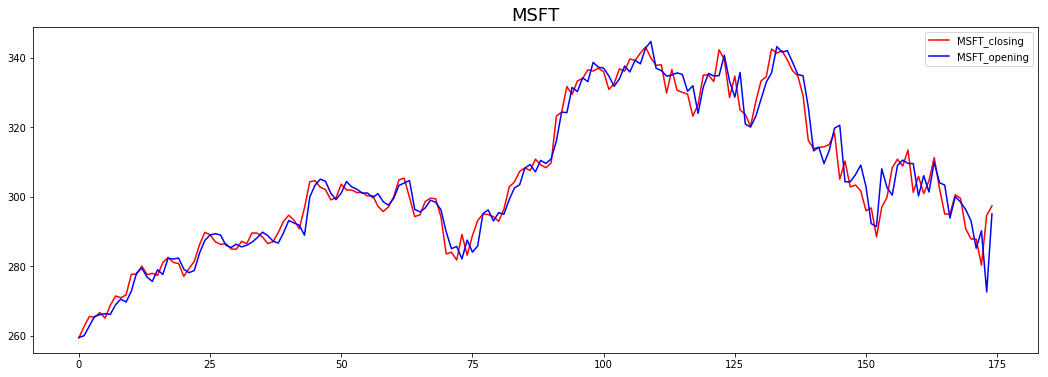

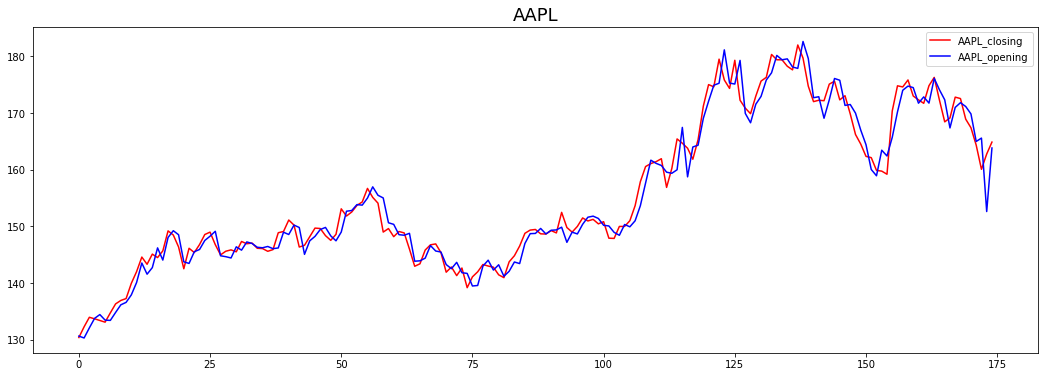

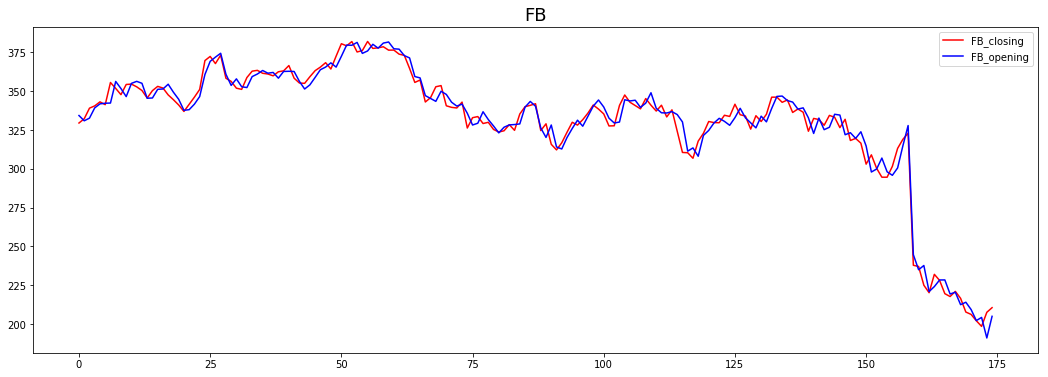

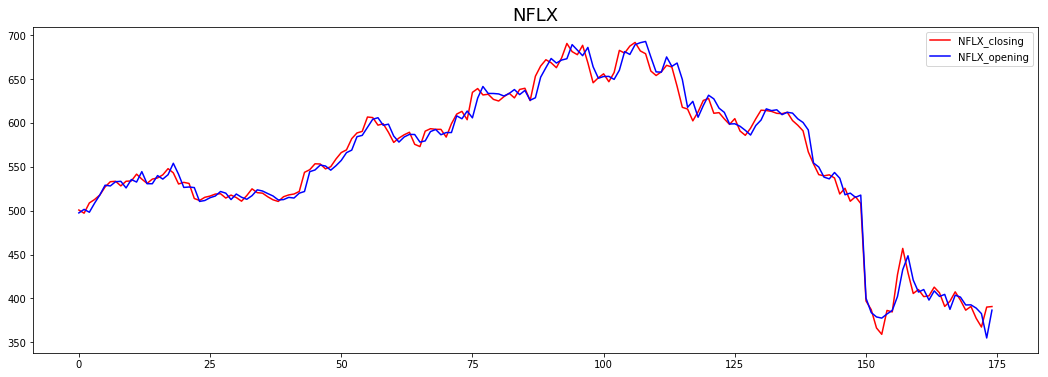

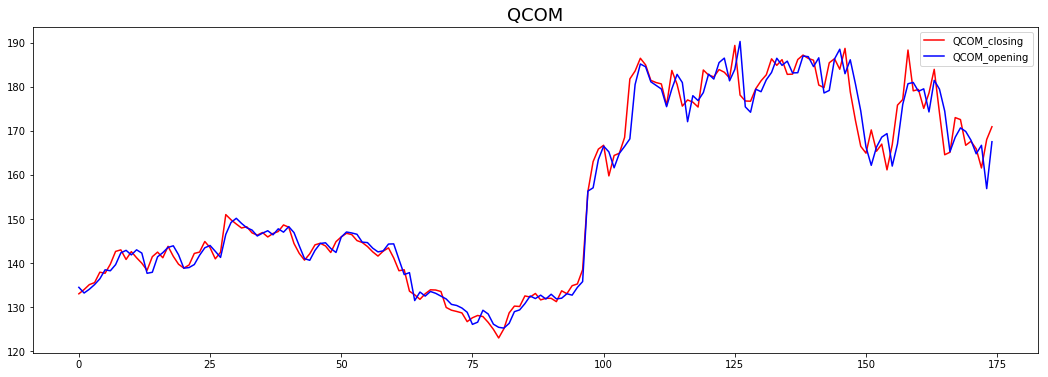

In [ ]:
stocks = ['MSFT', 'AAPL', 'FB', 'NFLX','QCOM']
stock = stocks[0]
days = 175
days_left = 75
for i in range(len(stocks)):
  # print(stocks[i])
  trade = TradingStrategy(stocks[i])
  close = trade.get_past_closing_prices(days)
  open = trade.get_past_opening_prices(days)

  fig = plt.figure(figsize=(18,6))
  plt.plot(close, label = str(stocks[i])+'_closing', c = 'r')
  plt.plot(open, label = str(stocks[i])+'_opening', c = 'b')
  plt.title(stocks[i], size = 18)
  plt.legend()

In [ ]:
%%capture
stock_df = pd.DataFrame(columns=[stocks[0]+'_close',stocks[1]+'_close',stocks[2]+'_close',stocks[3]+'_close',stocks[4]+'_close',
                                        stocks[0]+'_open',stocks[1]+'_open',stocks[2]+'_open',stocks[3]+'_open',stocks[4]+'_open'])

for stock in stock_df.columns:
    temp = stock
    stock = stock.split('_')[0]
    strategy = TradingStrategy(stock)
    if '_close' in stock:
        closing = strategy.get_past_closing_prices(days+days_left)
        stock_df[temp] = closing
    else: 
        closing = strategy.get_past_opening_prices(days+days_left)
        stock_df[temp] = closing

# Save the data to local directory 
PATH = './stockprice.csv'
stock_df.to_csv(PATH)

In [ ]:
print(stock_df.head())
print(stock_df.shape)

   MSFT_close  AAPL_close  FB_close  ...  FB_open  NFLX_open  QCOM_open
0    232.1550      124.81   260.290  ...  260.290     545.93    135.600
1    226.7350      121.75   256.470  ...  256.470     521.50    132.350
2    229.5165      120.98   260.670  ...  260.670     511.98    130.920
3    231.3700      120.93   265.550  ...  265.550     514.46    129.000
4    232.8800      119.03   261.175  ...  261.175     507.31    127.385

[5 rows x 10 columns]
(250, 10)


In [ ]:
datetime_list = strategy.get_date('test')
date_list = strategy.get_date('train')

In [ ]:
import copy
stock_df_datetime = copy.deepcopy(stock_df)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#date_index = pd.DatetimeIndex(date_list, yearfirst= True)
stock_df['date'] = date_list
temp = stock_df.set_index('date', drop = True,inplace = True)
stock_df.head()

,MSFT_close,AAPL_close,FB_close,NFLX_close,QCOM_close,MSFT_open,AAPL_open,FB_open,NFLX_open,QCOM_open
date,,,,,,,,,,
2021-03-03,232.1550,124.81,260.290,545.93,135.600,232.1550,124.81,260.290,545.93,135.600
2021-03-04,226.7350,121.75,256.470,521.50,132.350,226.7350,121.75,256.470,521.50,132.350
2021-03-05,229.5165,120.98,260.670,511.98,130.920,229.5165,120.98,260.670,511.98,130.920
2021-03-08,231.3700,120.93,265.550,514.46,129.000,231.3700,120.93,265.550,514.46,129.000
2021-03-09,232.8800,119.03,261.175,507.31,127.385,232.8800,119.03,261.175,507.31,127.385


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#date_index = pd.DatetimeIndex(date_list, yearfirst= True)
stock_df_datetime['date'] = datetime_list
temp = stock_df_datetime.set_index('date', drop = True,inplace = True)
stock_df_datetime.head()

,MSFT_close,AAPL_close,FB_close,NFLX_close,QCOM_close,MSFT_open,AAPL_open,FB_open,NFLX_open,QCOM_open
date,,,,,,,,,,
2021-03-03,232.1550,124.81,260.290,545.93,135.600,232.1550,124.81,260.290,545.93,135.600
2021-03-04,226.7350,121.75,256.470,521.50,132.350,226.7350,121.75,256.470,521.50,132.350
2021-03-05,229.5165,120.98,260.670,511.98,130.920,229.5165,120.98,260.670,511.98,130.920
2021-03-08,231.3700,120.93,265.550,514.46,129.000,231.3700,120.93,265.550,514.46,129.000
2021-03-09,232.8800,119.03,261.175,507.31,127.385,232.8800,119.03,261.175,507.31,127.385


In [ ]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
statsmodels.__version__

'0.12.2'

<Figure size 720x720 with 0 Axes>

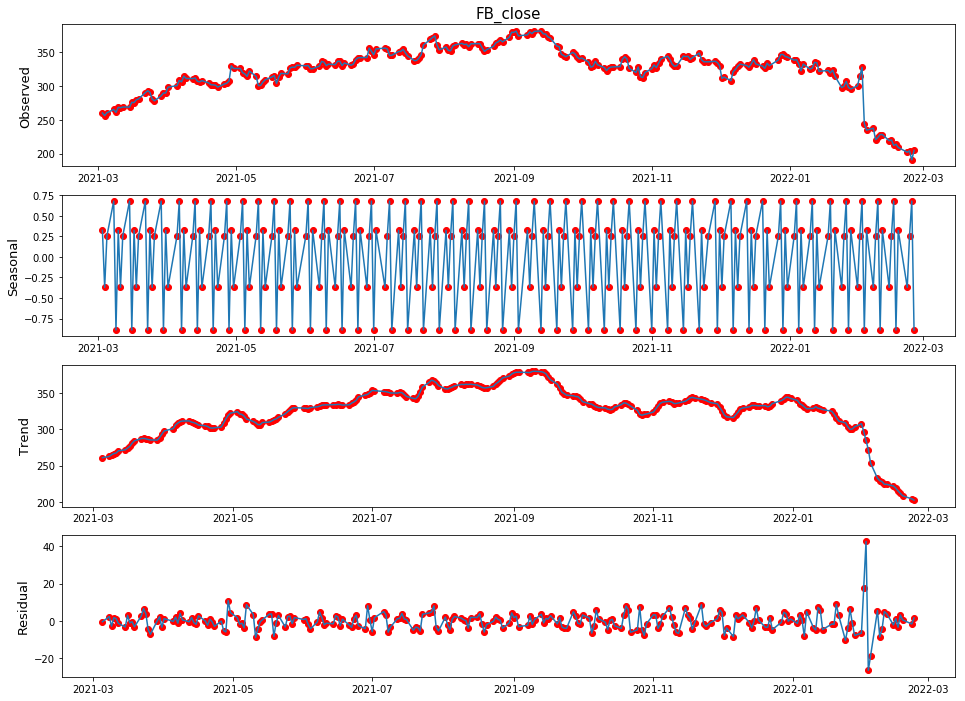

In [ ]:
stock = 2
result = seasonal_decompose(stock_df[stock_df.columns[stock]],model = 'add', period=5)
# result = seasonal_decompose(stock_df[stock_df.columns[stock]],model = 'mul', period=5)
fig = plt.figure(figsize=(10,10))
all_data = [result.observed, result.seasonal, result.trend, result.resid]

_type = ['Observed', 'Seasonal','Trend', 'Residual']
fig = plt.figure(figsize=(16,12))
for i in range(len(all_data)):
    plt.subplot(len(all_data),1,i+1)
    if i == 0:
        plt.title(stock_df.columns[stock],  size = 15) 
    plt.plot(all_data[i], 'o', c= 'r')
    plt.plot(all_data[i], '-')
    plt.ylabel(_type[i], size = 13)

In [ ]:
# simple moving average (SMA)
def sma(data, n):
    sma = data.rolling(window = n).mean()
    sma[0:n-1] = data[0:n-1]
    return pd.DataFrame(sma)

#windows = [10, 20, 50]
windows = [5, 7 , 11, 21, 51]
newCol = []
for window in windows: 
    for col in stock_df.columns:
        newCol.append( col +'_' + str(window))

sma_df = pd.DataFrame(columns=newCol)
for col in newCol:
    temp = col.rsplit('_', 1)
    sma_df[col] = sma(stock_df[temp[0]], int(temp[1]))

sma_df.head()

,MSFT_close_5,AAPL_close_5,FB_close_5,NFLX_close_5,QCOM_close_5,MSFT_open_5,AAPL_open_5,FB_open_5,NFLX_open_5,QCOM_open_5,MSFT_close_7,AAPL_close_7,FB_close_7,NFLX_close_7,QCOM_close_7,MSFT_open_7,AAPL_open_7,FB_open_7,NFLX_open_7,QCOM_open_7,MSFT_close_11,AAPL_close_11,FB_close_11,NFLX_close_11,QCOM_close_11,MSFT_open_11,AAPL_open_11,FB_open_11,NFLX_open_11,QCOM_open_11,MSFT_close_21,AAPL_close_21,FB_close_21,NFLX_close_21,QCOM_close_21,MSFT_open_21,AAPL_open_21,FB_open_21,NFLX_open_21,QCOM_open_21,MSFT_close_51,AAPL_close_51,FB_close_51,NFLX_close_51,QCOM_close_51,MSFT_open_51,AAPL_open_51,FB_open_51,NFLX_open_51,QCOM_open_51
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-03,232.1550,124.81,260.290,545.930,135.600,232.1550,124.81,260.290,545.930,135.600,232.1550,124.81,260.290,545.93,135.600,232.1550,124.81,260.290,545.93,135.600,232.1550,124.81,260.290,545.93,135.600,232.1550,124.81,260.290,545.93,135.600,232.1550,124.81,260.290,545.93,135.600,232.1550,124.81,260.290,545.93,135.600,232.1550,124.81,260.290,545.93,135.600,232.1550,124.81,260.290,545.93,135.600
2021-03-04,226.7350,121.75,256.470,521.500,132.350,226.7350,121.75,256.470,521.500,132.350,226.7350,121.75,256.470,521.50,132.350,226.7350,121.75,256.470,521.50,132.350,226.7350,121.75,256.470,521.50,132.350,226.7350,121.75,256.470,521.50,132.350,226.7350,121.75,256.470,521.50,132.350,226.7350,121.75,256.470,521.50,132.350,226.7350,121.75,256.470,521.50,132.350,226.7350,121.75,256.470,521.50,132.350
2021-03-05,229.5165,120.98,260.670,511.980,130.920,229.5165,120.98,260.670,511.980,130.920,229.5165,120.98,260.670,511.98,130.920,229.5165,120.98,260.670,511.98,130.920,229.5165,120.98,260.670,511.98,130.920,229.5165,120.98,260.670,511.98,130.920,229.5165,120.98,260.670,511.98,130.920,229.5165,120.98,260.670,511.98,130.920,229.5165,120.98,260.670,511.98,130.920,229.5165,120.98,260.670,511.98,130.920
2021-03-08,231.3700,120.93,265.550,514.460,129.000,231.3700,120.93,265.550,514.460,129.000,231.3700,120.93,265.550,514.46,129.000,231.3700,120.93,265.550,514.46,129.000,231.3700,120.93,265.550,514.46,129.000,231.3700,120.93,265.550,514.46,129.000,231.3700,120.93,265.550,514.46,129.000,231.3700,120.93,265.550,514.46,129.000,231.3700,120.93,265.550,514.46,129.000,231.3700,120.93,265.550,514.46,129.000
2021-03-09,230.5313,121.50,260.831,520.236,131.051,230.5313,121.50,260.831,520.236,131.051,232.8800,119.03,261.175,507.31,127.385,232.8800,119.03,261.175,507.31,127.385,232.8800,119.03,261.175,507.31,127.385,232.8800,119.03,261.175,507.31,127.385,232.8800,119.03,261.175,507.31,127.385,232.8800,119.03,261.175,507.31,127.385,232.8800,119.03,261.175,507.31,127.385,232.8800,119.03,261.175,507.31,127.385


In [ ]:
# calculate EMA 
def ema(values, period):
    return values.ewm(span=period).mean()

ema_df = pd.DataFrame(columns=newCol)
for col in newCol:
    temp = col.rsplit('_', 1)
    ema_df[col] = ema(stock_df[temp[0]], int(temp[1]))

ema_df.head()

,MSFT_close_5,AAPL_close_5,FB_close_5,NFLX_close_5,QCOM_close_5,MSFT_open_5,AAPL_open_5,FB_open_5,NFLX_open_5,QCOM_open_5,MSFT_close_7,AAPL_close_7,FB_close_7,NFLX_close_7,QCOM_close_7,MSFT_open_7,AAPL_open_7,FB_open_7,NFLX_open_7,QCOM_open_7,MSFT_close_11,AAPL_close_11,FB_close_11,NFLX_close_11,QCOM_close_11,MSFT_open_11,AAPL_open_11,FB_open_11,NFLX_open_11,QCOM_open_11,MSFT_close_21,AAPL_close_21,FB_close_21,NFLX_close_21,QCOM_close_21,MSFT_open_21,AAPL_open_21,FB_open_21,NFLX_open_21,QCOM_open_21,MSFT_close_51,AAPL_close_51,FB_close_51,NFLX_close_51,QCOM_close_51,MSFT_open_51,AAPL_open_51,FB_open_51,NFLX_open_51,QCOM_open_51
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-03,232.155000,124.810000,260.290000,545.930000,135.600000,232.155000,124.810000,260.290000,545.930000,135.600000,232.155000,124.810000,260.290000,545.930000,135.600000,232.155000,124.810000,260.290000,545.930000,135.600000,232.155000,124.810000,260.290000,545.930000,135.600000,232.155000,124.810000,260.290000,545.930000,135.600000,232.155000,124.810000,260.290000,545.930000,135.600000,232.155000,124.810000,260.290000,545.930000,135.600000,232.155000,124.810000,260.290000,545.930000,135.600000,232.155000,124.810000,260.290000,545.930000,135.600000
2021-03-04,228.903000,122.974000,257.998000,531.272000,133.650000,228.903000,122.974000,257.998000,531.272000,133.650000,229.057857,123.061429,258.107143,531.970000,133.742857,229.057857,123.061429,258.107143,531.970000,133.742857,229.198636,123.140909,258.206364,532.604545,133.827273,229.198636,123.140909,258.206364,532.604545,133.827273,229.315952,123.207143,258.289048,533.133333,133.897619,229.315952,123.207143,258.289048,533.133333,133.897619,229.391863,123.250000,258.342549,533.475490,133.943137,229.391863,123.250000,258.342549,533.475490,133.943137
2021-03-05,229.193605,122.029474,259.263684,522.133684,132.356842,229.193605,122.029474,259.263684,522.133684,132.356842,229.256189,122.161351,259.215405,523.325676,132.522162,229.256189,122.161351,259.215405,523.325676,132.522162,229.324385,122.286044,259.180989,524.445385,132.677143,229.324385,122.286044,259.180989,524.445385,132.677143,229.389264,122.392991,259.159426,525.400544,132.809124,229.389264,122.392991,259.159426,525.400544,132.809124,229.435048,122.463470,259.148985,526.027540,132.895654,229.435048,122.463470,259.148985,526.027540,132.895654
2021-03-08,230.097646,121.572769,261.874923,518.946154,130.962462,230.097646,121.572769,261.874923,518.946154,130.962462,230.029240,121.711029,261.532057,520.083371,131.234057,230.029240,121.711029,261.532057,520.083371,131.234057,229.982884,121.849523,261.231222,521.231013,131.493443,229.982884,121.849523,261.231222,521.231013,131.493443,229.957323,121.973417,260.992189,522.262887,131.716699,229.957323,121.973417,260.992189,522.262887,131.716699,229.947606,122.057263,260.844577,522.963365,131.863717,229.947606,122.057263,260.844577,522.963365,131.863717
2021-03-09,231.165754,120.596635,261.606232,514.479194,129.589123,231.165754,120.596635,261.606232,514.479194,129.589123,230.963676,120.832228,261.415019,515.896453,129.972394,230.963676,120.832228,261.415019,515.896453,129.972394,230.790164,121.063864,261.215556,517.351926,130.348626,230.790164,121.063864,261.215556,517.351926,130.348626,230.658227,121.267539,261.036030,518.676947,130.677889,230.658227,121.267539,261.036030,518.676947,130.677889,230.580967,121.403411,260.915945,519.582432,130.896370,230.580967,121.403411,260.915945,519.582432,130.896370


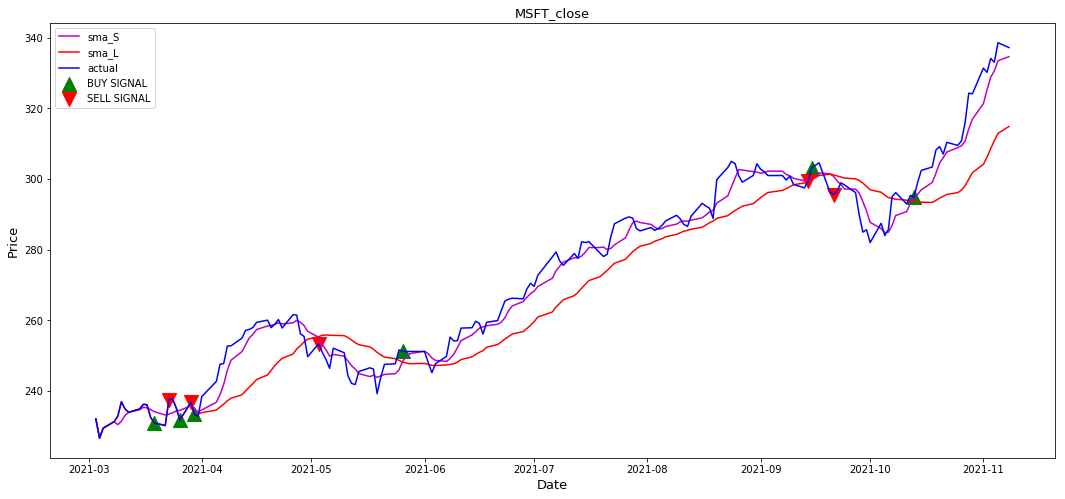

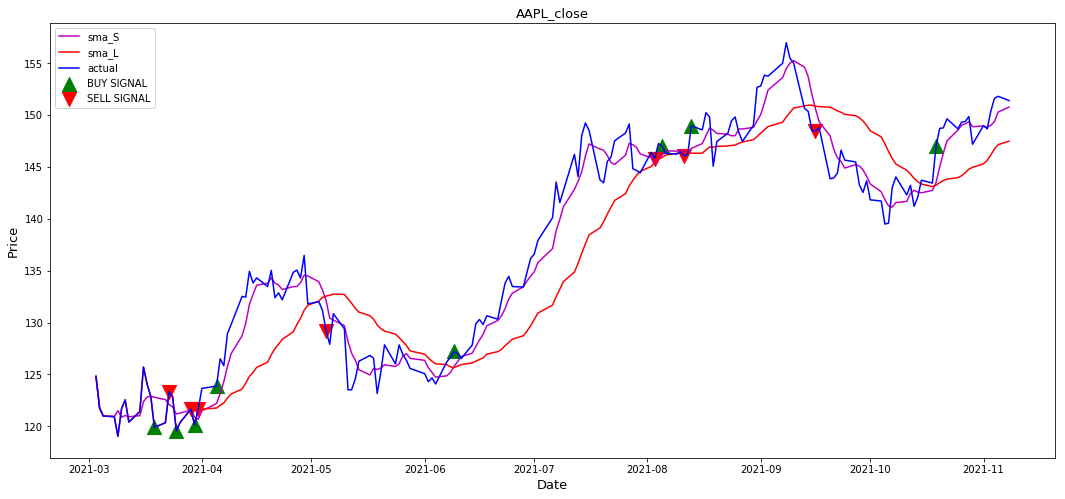

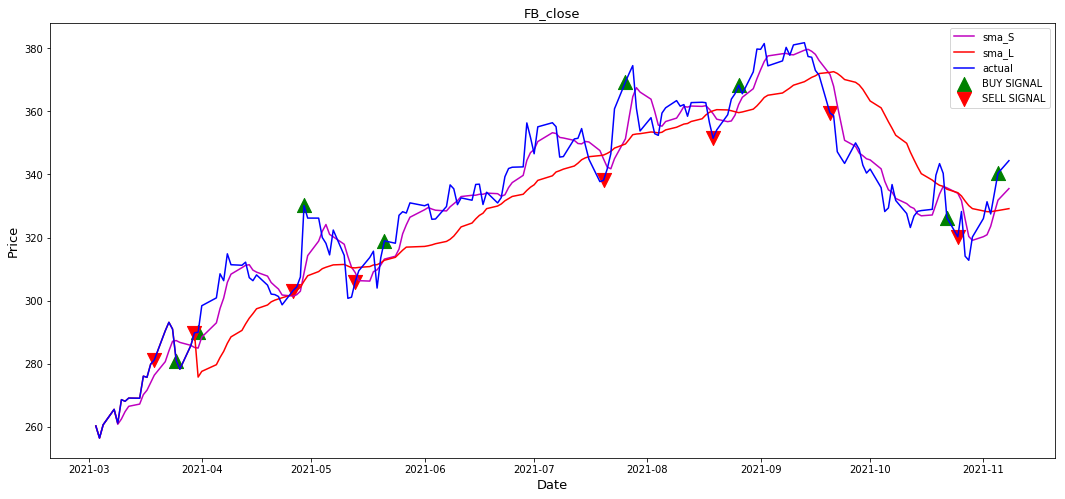

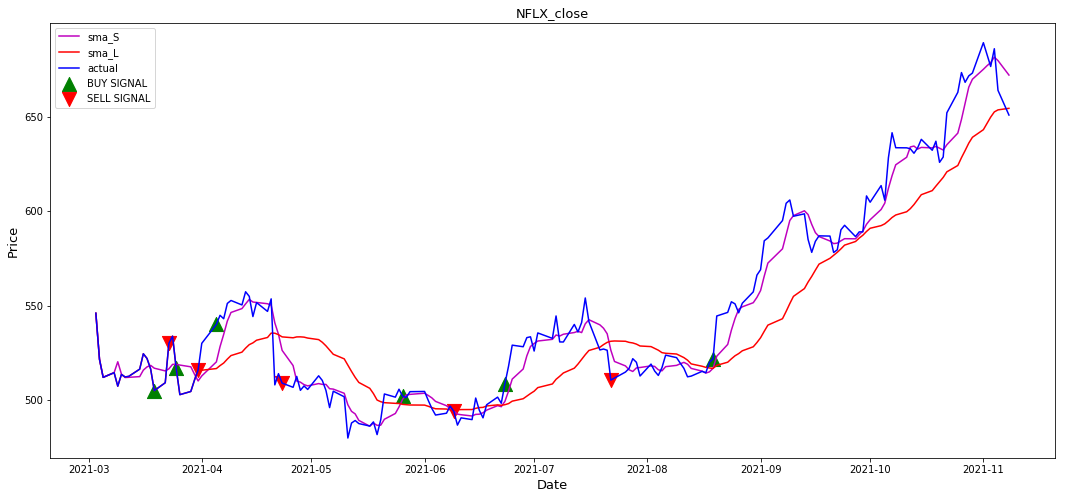

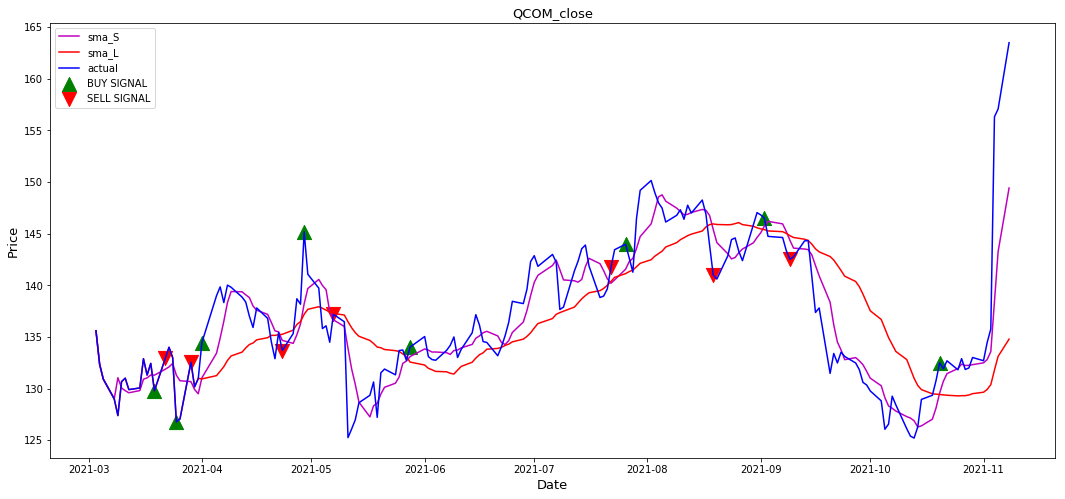

In [ ]:
# training on 7 months of data.
for i in range(len(stocks)):
  # plot few elements to check
  fig = plt.figure(figsize=(18,8))
  points = days
  start = i # 0-9
  step = 30 # either 10 or 20
  big = 11
  buy_price , sell_price, trade_signal = strategy.buy_sell_strategy(stock_df[stock_df.columns[start]],sma_df[sma_df.columns[start]],sma_df[sma_df.columns[start+step]],big)
  df_buy_sell = pd.DataFrame(index = date_list)
  df_buy_sell['buy_price'] = buy_price
  df_buy_sell['sell_price'] = sell_price
  df_buy_sell['trade_signal'] = trade_signal
  #print(df_buy_sell)
  plt.plot(sma_df[sma_df.columns[start]][0:points], c= 'm', label = 'sma_S')
  #plt.plot(ema_df[ema_df.columns[start]][0:points], c= 'k', label = 'ema_S')
  plt.plot(sma_df[sma_df.columns[start+step]][0:points], c= 'r', label = 'sma_L')
  #plt.plot(ema_df[ema_df.columns[start+step]][0:points], c= 'g', label = 'ema_L')
  plt.plot(stock_df[stock_df.columns[start]][0:points], c= 'b', label = 'actual')

  plt.scatter(stock_df.index[0:points],df_buy_sell['buy_price'][0:points], marker = '^', s = 200, color = 'g', label = 'BUY SIGNAL')
  plt.scatter(stock_df.index[0:points],df_buy_sell['sell_price'][0:points], marker = 'v', s = 200, color = 'red', label = 'SELL SIGNAL')
  # plt.axvline(x= 153)
  plt.title(stock_df.columns[start], size = 13)
  plt.xlabel("Date", size = 13)
  plt.ylabel("Price", size = 13)
  plt.legend()

In [ ]:
  print(stock_df[stock_df.columns[start]][0])

135.6


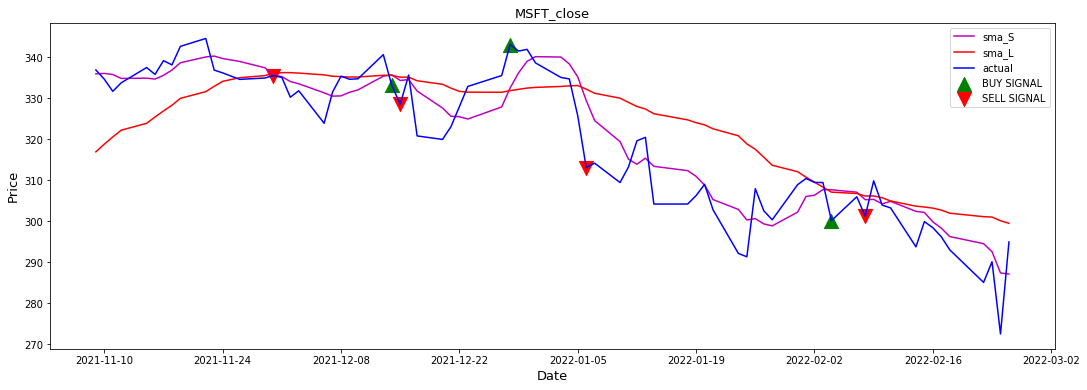

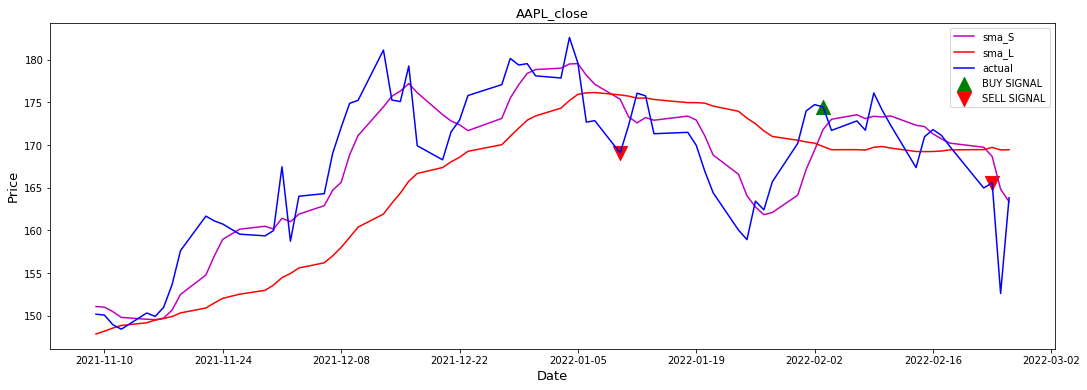

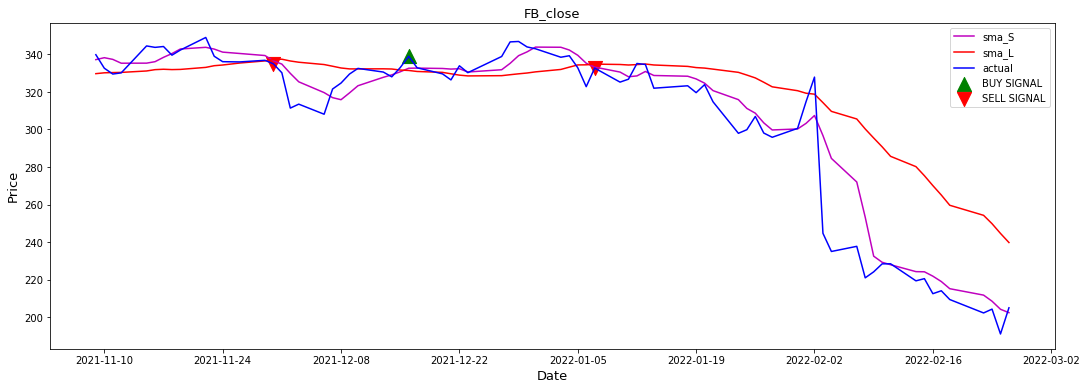

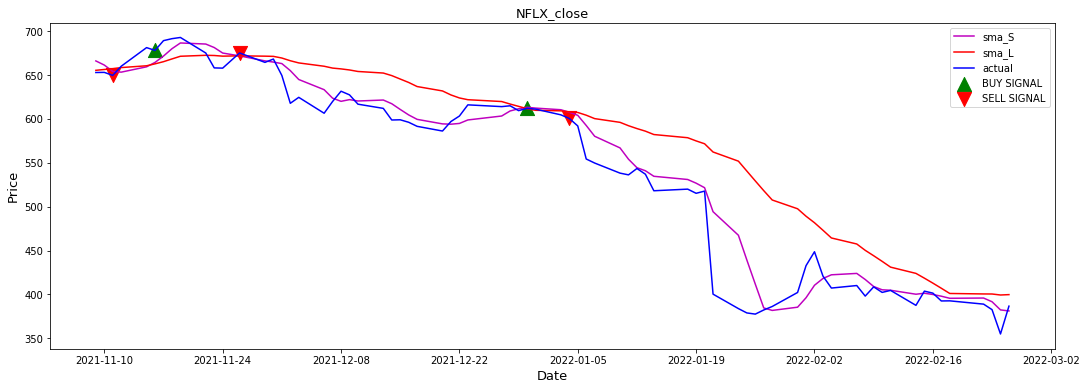

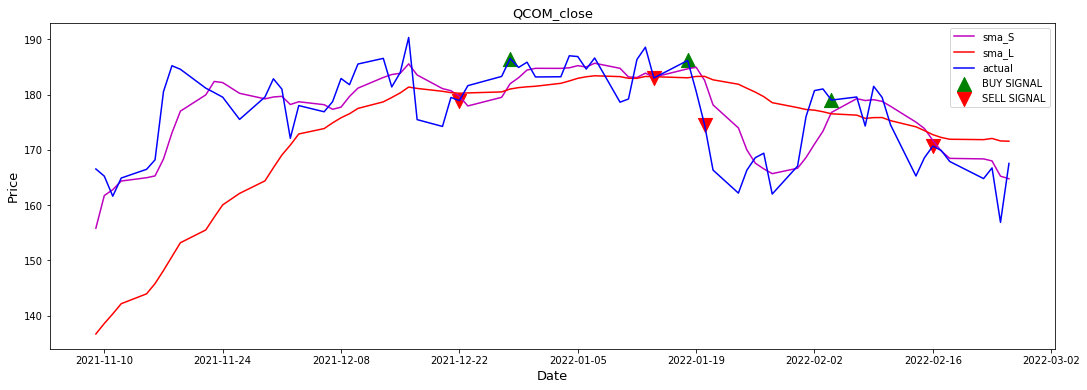

In [ ]:
# last 5 month data 
for i in range(len(stocks)):
  # plot few elements to check
  fig = plt.figure(figsize=(18,6))
  points = days
  start = i # 0-9
  step = 30 # either 10 or 20
  big = 11
  buy_price , sell_price, trade_signal = strategy.buy_sell_strategy(stock_df[stock_df.columns[start]],sma_df[sma_df.columns[start]],sma_df[sma_df.columns[start+step]],big)
  df_buy_sell = pd.DataFrame(index = date_list)
  df_buy_sell['buy_price'] = buy_price
  df_buy_sell['sell_price'] = sell_price
  df_buy_sell['trade_signal'] = trade_signal
  #print(df_buy_sell)
  plt.plot(sma_df[sma_df.columns[start]][days: days+days_left], c= 'm', label = 'sma_S')
  # plt.plot(ema_df[ema_df.columns[start]][days: days+days_left], c= 'k', label = 'ema_S')
  plt.plot(sma_df[sma_df.columns[start+step]][days: days+days_left], c= 'r', label = 'sma_L')
  # plt.plot(ema_df[ema_df.columns[start+step]][days: days+days_left], c= 'g', label = 'ema_L')
  plt.plot(stock_df[stock_df.columns[start]][days: days+days_left], c= 'b', label = 'actual')

  plt.scatter(stock_df.index[days:(days+ days_left)],df_buy_sell['buy_price'][days:(days+ days_left)], marker = '^', s = 200, color = 'g', label = 'BUY SIGNAL')
  plt.scatter(stock_df.index[days:(days+ days_left)],df_buy_sell['sell_price'][days:days+ days_left], marker = 'v', s = 200, color = 'red', label = 'SELL SIGNAL')
  # plt.axvline(x= 153)
  plt.title(stock_df.columns[start], size = 13)
  plt.xlabel("Date", size = 13)
  plt.ylabel("Price", size = 13)
  plt.legend()

In [ ]:
## get buy and sell points
# stock = 0
# idx = 20 ## selects 50 window 
# buy,sell,sig = strategy.buy_sell_strategy(stock_df[stock_df.columns[stock]], sma_df[sma_df.columns[stock]], sma_df[sma_df.columns[stock+idx]])

In [ ]:
# df = pd.DataFrame(buy , columns = ['buy_price'])
# df['sell_price'] = sell
# df['signal'] = sig

In [ ]:
# sell_count = 0
# buy_count = 0
# for x in sig: 
#     if x == -1 : 
#         sell_count += 1 
#     elif  x == 1: 
#         buy_count += 1
# sell_count, buy_count

## Second Strategy

In [ ]:
stocks = ['MSFT', 'AAPL', 'FB', 'NFLX','QCOM']
allPrices = []
days = 250
train_days = 175
test_days = days - train_days
for stock in stocks: 
    tempStrategy = TradingStrategy(stock)
    temp = tempStrategy.get_all_price(days=days)
    for price in temp: 
        allPrices.append(price)

# stocks-Opening, Closing, High, Low     
price_tag = ["open", "close","high", "low"]
column_name = []
for stock in stocks:
    for tag in price_tag:
        column_name.append(stock + '_' + tag)

full_stock_df = pd.DataFrame(columns=column_name)
for i in range(len(full_stock_df.columns)): 
    full_stock_df[full_stock_df.columns[i]] = allPrices[i]

full_stock_df['date'] = datetime_list
full_stock_df.set_index('date', drop = True,inplace = True)
print("Shape of DataFrame: ",full_stock_df.shape)
full_stock_df.head()

Shape of DataFrame:  (250, 20)


,MSFT_open,MSFT_close,MSFT_high,MSFT_low,AAPL_open,AAPL_close,AAPL_high,AAPL_low,FB_open,FB_close,FB_high,FB_low,NFLX_open,NFLX_close,NFLX_high,NFLX_low,QCOM_open,QCOM_close,QCOM_high,QCOM_low
date,,,,,,,,,,,,,,,,,,,,
2021-03-03,232.1550,227.55,233.5799,227.28,124.81,122.06,125.710,121.84,260.290,255.44,260.9899,255.10,545.93,520.71,548.005,517.8100,135.600,131.66,136.1801,131.54
2021-03-04,226.7350,226.90,232.4900,224.26,121.75,120.22,123.600,118.62,256.470,257.59,266.4900,253.50,521.50,511.03,531.500,507.6800,132.350,127.80,134.2000,126.58
2021-03-05,229.5165,231.58,233.2700,226.46,120.98,121.39,121.935,117.57,260.670,264.28,265.4500,255.61,511.98,516.38,517.760,498.7901,130.920,129.75,131.1660,125.40
2021-03-08,231.3700,227.42,233.3650,227.13,120.93,116.40,121.000,116.21,265.550,255.44,265.5800,255.05,514.46,492.99,518.840,492.8500,129.000,123.18,129.7713,122.99
2021-03-09,232.8800,233.68,235.3839,231.67,119.03,121.08,122.060,118.79,261.175,265.74,268.5300,259.81,507.31,506.40,513.110,503.8221,127.385,129.11,129.9200,126.33


In [ ]:
MFM_list = []
count = 0
for stock in stocks: 
    temp = []
    tempStrategy = TradingStrategy(stock)
    for i in range(len(full_stock_df[full_stock_df.columns[0]])):
        tempMFM = tempStrategy.money_flow_multiplier(full_stock_df[stock + "_close"][i],full_stock_df[stock + "_high"][i], full_stock_df[stock + "_low"][i] )
        temp.append(tempMFM)
    MFM_list.append(temp)

MoneyFlowMultiplier_df = pd.DataFrame(columns=stocks)
for i in range(len(MoneyFlowMultiplier_df.columns)):
    MoneyFlowMultiplier_df[MoneyFlowMultiplier_df.columns[i]] = MFM_list[i]

MoneyFlowMultiplier_df['date'] = datetime_list
MoneyFlowMultiplier_df.set_index('date', drop = True,inplace = True)
MoneyFlowMultiplier_df.head()

,MSFT,AAPL,FB,NFLX,QCOM
date,,,,,
2021-03-03,-91.428435,-88.630491,-88.454812,-80.791522,-94.827698
2021-03-04,-35.844471,-35.742972,-37.028483,-71.872376,-67.979003
2021-03-05,50.367107,75.028637,76.219512,85.450635,50.884495
2021-03-08,-90.697674,-92.066806,-92.592593,-98.922663,-94.396355
2021-03-09,8.242010,40.061162,36.009174,-44.489066,54.874652


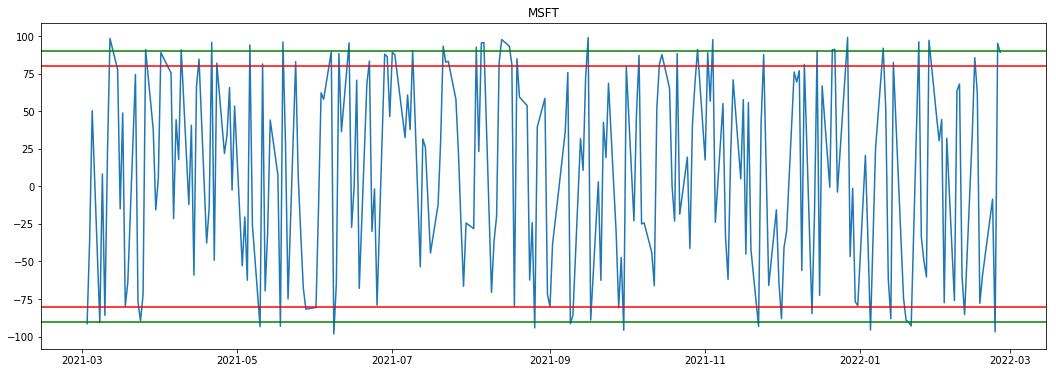

In [ ]:
fig = plt.figure(figsize=(18,6))
plt.plot(MoneyFlowMultiplier_df[MoneyFlowMultiplier_df.columns[0]])
plt.title(MoneyFlowMultiplier_df.columns[0])
plt.axhline(y= -90, c= 'g')
plt.axhline(y= 90, c= 'g')
plt.axhline(y= -80, c= 'r')
plt.axhline(y= 80, c= 'r')

In [ ]:
for stock in stocks:
    tempStrategy = TradingStrategy(stock)
    tempSignal = tempStrategy.signals_MFM(MoneyFlowMultiplier_df[stock])
    tempBuy = [np.nan for x in tempSignal]
    tempSell = [np.nan for x in tempSignal]
    for i in range(len(tempSignal)):
        if tempSignal[i] == 1: 
            tempBuy[i] = full_stock_df[stock + "_close"][i]
        elif tempSignal[i] == -1:
            tempSell[i] = full_stock_df[stock + "_close"][i]
    
    MoneyFlowMultiplier_df[stock+"_signal"] = tempSignal
    MoneyFlowMultiplier_df[stock+"_buy"] = tempBuy
    MoneyFlowMultiplier_df[stock+"_sell"] = tempSell


MoneyFlowMultiplier_df.head()

,MSFT,AAPL,FB,NFLX,QCOM,MSFT_signal,MSFT_buy,MSFT_sell,AAPL_signal,AAPL_buy,AAPL_sell,FB_signal,FB_buy,FB_sell,NFLX_signal,NFLX_buy,NFLX_sell,QCOM_signal,QCOM_buy,QCOM_sell
date,,,,,,,,,,,,,,,,,,,,
2021-03-03,-91.428435,-88.630491,-88.454812,-80.791522,-94.827698,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
2021-03-04,-35.844471,-35.742972,-37.028483,-71.872376,-67.979003,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
2021-03-05,50.367107,75.028637,76.219512,85.450635,50.884495,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
2021-03-08,-90.697674,-92.066806,-92.592593,-98.922663,-94.396355,1,227.42,NaN,1,116.4,NaN,1,255.44,NaN,1,492.99,NaN,1,123.18,NaN
2021-03-09,8.242010,40.061162,36.009174,-44.489066,54.874652,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN


# Plot the time-series of the stocks over past 5 months and indicate using markers where your algorithm buys and sells

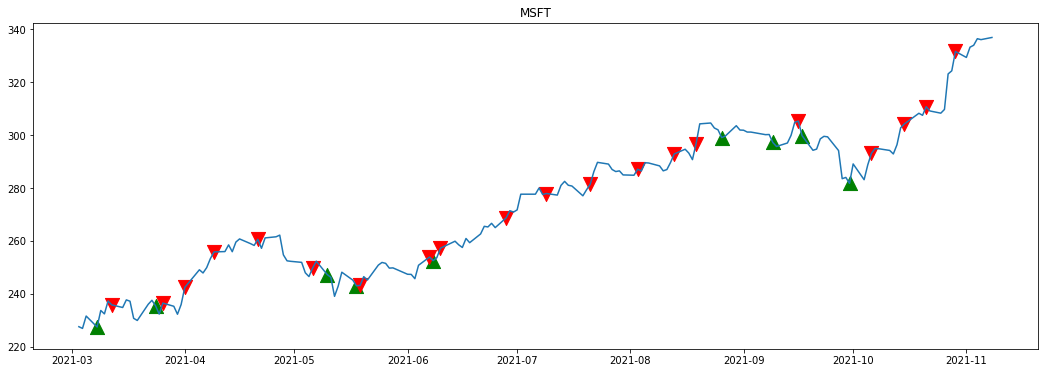

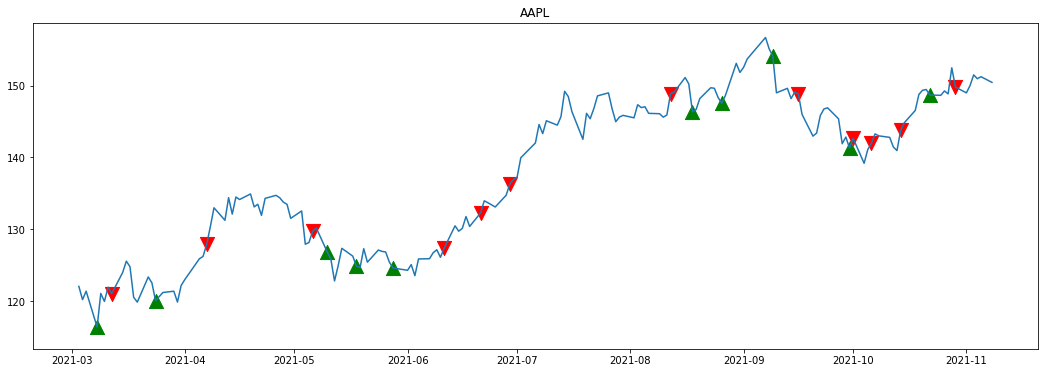

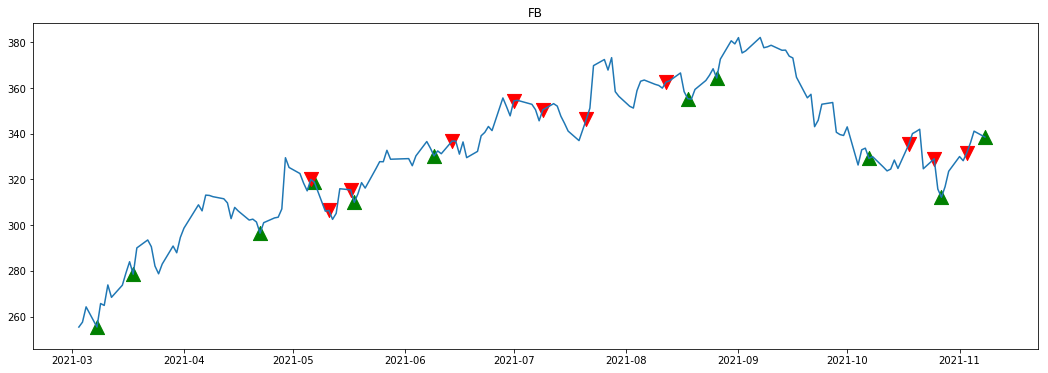

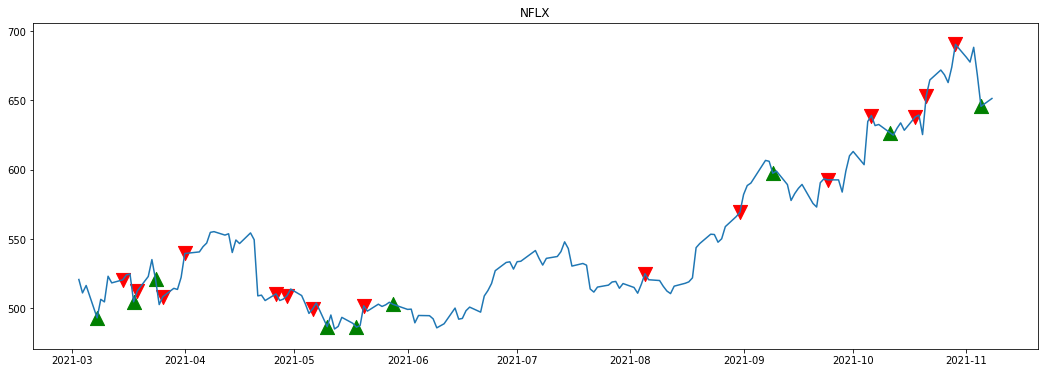

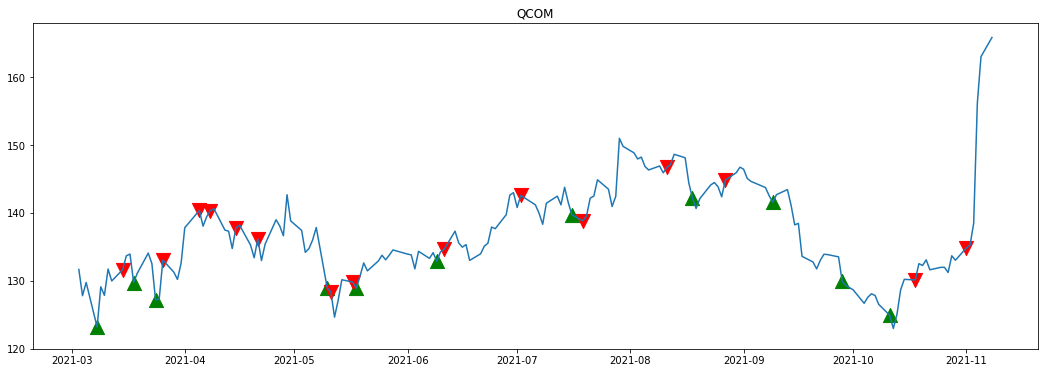

In [ ]:
## Training 
for stock in stocks:
    fig = plt.figure(figsize=(18,6))
    plt.plot(full_stock_df[stock + "_close"][0:train_days])
    # plt.plot(full_stock_df[stock + "_close"][0:train_days], '-',c = 'gray')
    plt.scatter(full_stock_df.index[0:train_days], MoneyFlowMultiplier_df[stock+"_buy"][0:train_days], marker = '^', s = 200, color = 'g', label = 'BUY SIGNAL')
    plt.scatter(full_stock_df.index[0:train_days], MoneyFlowMultiplier_df[stock+"_sell"][0:train_days], marker = 'v', s = 200, color = 'r', label = 'BUY SIGNAL')
    plt.title(stock)


# Supervised learning 

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', max_iter= 1000)


In [ ]:
# ## get dataframe
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark import SparkContext
from pyspark.sql import SQLContext

d = {}
for stock in stocks:
  d['df_'+str(stock)] = pd.DataFrame(columns = [stock+"_close",stock+"_open",stock+"_high",stock+"_low",'signal'])

for stock in stocks:
  d['df_'+stock][stock+"_close"] = full_stock_df[stock+"_close"]
  d['df_'+stock][stock+"_open"] = full_stock_df[stock+"_open"]
  d['df_'+stock][stock+"_high"] = full_stock_df[stock+"_high"]
  d['df_'+stock][stock+"_low"] = full_stock_df[stock+"_low"]
  d['df_'+stock]['signal'] = MoneyFlowMultiplier_df[stock +'_signal']

print("Keys in Dictionary DF: ",d.keys())
d['df_MSFT']

theList = []
for stock in stocks: 
  tempList = []
  for i in range(d['df_' + stock].shape[0]):
    tempList.append((d['df_' + stock].iloc[i]).tolist() ) 
  theList.append(tempList) 

for i in range(len(theList)):
  for j in range(len(theList[0])):
    del theList[i][j][-1] 

# theList[0]
model_d ={}
for i in range(len(stocks)): 
  # x_input = d['df_'+stock][stock+"_close"]
  # X_input = np.array(x_input.tolist()).reshape(-1,1)
  model_d['model_'+stocks[i]] = model.fit(theList[i], d['df_'+stocks[i]]["signal"])

display("model dictionary: ", model_d)

def get_all_price(STOCK, days):
  barset = rest_api.get_barset(STOCK, 'day', limit= days) 
  bars = barset[STOCK]
  closing_prices = [bars[index].c for index in range(len(bars))]
  open_prices = [bars[index].o for index in range(len(bars))]
  high_prices = [bars[index].h for index in range(len(bars))]
  low_prices = [bars[index].l for index in range(len(bars))]

  tempList = []
  for i in range(len(closing_prices)):
    tempList.append( [closing_prices[i], open_prices[i], high_prices[i], low_prices[i]])
  
  return tempList

test_d ={}
for stock in stocks:
  test_d ['test_'+ stock] = get_all_price(stock, 150)

print("test dictionary key: ", test_d.keys())

predict_d = {}
for stock in stocks:
  predict_d["predict_"+ stock] = model_d['model_'+stock].predict(test_d['test_'+ stock])

print("predict dictionary key: ", predict_d.keys())
signal = predict_d['predict_QCOM'].tolist()
# signal

Keys in Dictionary DF:  dict_keys(['df_MSFT', 'df_AAPL', 'df_FB', 'df_NFLX', 'df_QCOM'])


'model dictionary: '

{'model_AAPL': LogisticRegression(max_iter=1000, multi_class='multinomial'),
 'model_FB': LogisticRegression(max_iter=1000, multi_class='multinomial'),
 'model_MSFT': LogisticRegression(max_iter=1000, multi_class='multinomial'),
 'model_NFLX': LogisticRegression(max_iter=1000, multi_class='multinomial'),
 'model_QCOM': LogisticRegression(max_iter=1000, multi_class='multinomial')}

test dictionary key:  dict_keys(['test_MSFT', 'test_AAPL', 'test_FB', 'test_NFLX', 'test_QCOM'])
predict dictionary key:  dict_keys(['predict_MSFT', 'predict_AAPL', 'predict_FB', 'predict_NFLX', 'predict_QCOM'])


# Backtesting - From Scratch

In [ ]:
class BackTester:
    def __init__(self,STOCK):
      self.api = alpaca.REST(API_KEY_ID, SECRET_KEY, ENDPOINT)
      self.STOCK = STOCK
      self.days = 365
      self.MFM_dataframe = pd.DataFrame()
      self.get_all_price(self.days)
      self.high = 0
      self.low = 0
      self.close = 0
      self.principal = 0
      self.money_flow_multiplier(self.close, self.high, self.low)
      self.getMFMDataframe()
      self.signals_MFM()
      self.signal = []
      self.data = pd.DataFrame()
      self.calculate_profit(self.principal)
      self.logistic_profit(self.data, self.principal, self.signal)

    def get_all_price(self, days):
        barset = self.api.get_barset(self.STOCK, 'day', limit= days) 
        bars = barset[self.STOCK]
        self.opening_prices = [bars[index].o for index in range(len(bars))]
        self.closing_prices = [bars[index].c for index in range(len(bars))]
        self.high_price = [bars[index].h for index in range(len(bars))]
        #print(self.high_price)
        self.low_price = [bars[index].l for index in range(len(bars))]
        self.all_df = pd.DataFrame(columns=['open', 'close', 'high', 'low'])
        self.all_df['open'] = self.opening_prices
        self.all_df['close'] = self.closing_prices
        self.all_df['high'] = self.high_price
        self.all_df['low'] = self.low_price
        return self.all_df

    def money_flow_multiplier(self, close, high, low):
        diff = high-low
        if diff == 0:
            diff = 1e-3

        multiplier = ((close-low) - (high -close))*100 / diff 
        return multiplier

    def getMFMDataframe(self):
        the_df = self.get_all_price(self.days)
        temp = []
        for i in range(len(the_df[the_df.columns[0]])):
          tempMFM = self.money_flow_multiplier(the_df["close"][i],the_df["high"][i], the_df["low"][i] )
          temp.append(tempMFM)
        self.MFMdataframe = pd.DataFrame(data = temp, columns = ['MFM'])
        return self.MFMdataframe

    def signals_MFM(self):
        #buy = 1 , no_action = 0, sell = -1 
        MFM_dataframe = self.getMFMDataframe() 
        low_thres = -85
        high_thres = 85
        list_signals = [0 for x in range(MFM_dataframe.shape[0])]
        index = 0 
        for i in range(2,len(MFM_dataframe)):
            if MFM_dataframe['MFM'][i] <= low_thres and (MFM_dataframe['MFM'][i-1] >= low_thres and MFM_dataframe['MFM'][i-2] >= low_thres):
                list_signals[i] = 1
                if index == 0:
                    index = i

            elif MFM_dataframe['MFM'][i] >= high_thres and (MFM_dataframe['MFM'][i-1] <= high_thres and MFM_dataframe['MFM'][i-2] <= high_thres): 
                list_signals[i] = -1
                
        for i in range(len(list_signals)):
            if i < index:
                list_signals[i] = 0 
        
        return list_signals

    def calculate_profit(self, principal):
          signals_list = self.signals_MFM()
          actual_df = self.get_all_price(self.days)
          price_list = []
          num_stock = []
          profit = 0
          principal_left = 0
          principal_invest = 0
          for i in range(len(signals_list)):
            if signals_list[i] == 1: 
              #print("principal: ", principal)
              amount = principal * 0.2
              if amount//actual_df["open"][i] == 0:
                amount = principal*0.5
                # print("Hi1",actual_df["open"][i])
                # print("Hi2",actual_df["open"][i])
              if principal//actual_df["open"][i] == 0:
                amount = principal
                # print("Hi3",actual_df["open"][i])
              #print("Amount", amount)
              num_stock.append(amount//actual_df["open"][i])
              principal -= (num_stock[-1]*actual_df["open"][i])
              price_list.append((num_stock[-1]*actual_df["open"][i])) 

            else:
              tempProfit = (actual_df["open"][i] * sum(num_stock)) - sum(price_list)
              if (tempProfit >= (0.1*sum(price_list)))  and (signals_list[i] == 0):
                profit += tempProfit
                principal += tempProfit
                principal_invest += sum(price_list)
                num_stock = []
                price_list = []
          principal_left = principal

          return profit, principal_left, principal_invest

    def logistic_profit(self, data, principal, signal): 
      signals_list = signal
      actual_df = data
      price_list = []
      num_stock = []
      profit = 0
      principal_left = 0
      principal_invest = 0
      # print("ddsfdfg",signals_list)
      for i in range(len(signals_list)):
        # print("Hdddsdsdff")
        if signals_list[i] == 1: 
          #print("principal: ", principal)
          amount = principal * 0.2
          if amount//actual_df[self.STOCK + "_open"][i] == 0:
            amount = principal*0.5
          if principal//actual_df[self.STOCK +"_open"][i] == 0:
            amount = principal
          #print("Amount", amount)
          num_stock.append(amount//actual_df[self.STOCK +"_open"][i])
          principal -= (num_stock[-1]*actual_df[self.STOCK +"_open"][i])
          price_list.append((num_stock[-1]*actual_df[self.STOCK +"_open"][i])) 
          # print("Hddff")

        else:
          tempProfit = (actual_df[self.STOCK +"_open"][i] * sum(num_stock)) - sum(price_list)
          if (tempProfit >= (-0.1*sum(price_list)))  and (signals_list[i] == 0):
            profit += tempProfit
            principal += tempProfit
            principal_invest += sum(price_list)
            num_stock = []
            price_list = []
            # print("HHHH")
      principal_left = principal

      return profit, principal_left, principal_invest

In [ ]:
### Money Flow Multiplier 
a = BackTester('MSFT')
z,p,l = a.calculate_profit(100000)
print("Profit:", z, ",Money Not Invested", p, ",Money Invested",l)

Profit: 11956.815000000024 ,Money Not Invested 1220.8800000000265 ,Money Invested 108165.515


In [ ]:
### Logistic Regression
a = BackTester("MSFT")
z,p,l = a.logistic_profit(d['df_MSFT'], 100000, signal)
print("Profit:", z, ",Money Not Invested", p, ",Money Invested",l)

Profit: 168.34000000000196 ,Money Not Invested 27007.760000000006 ,Money Invested 73160.57999999999


# LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import load_model
import copy
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [ ]:
norm = MinMaxScaler()
    
#args = [stock.values.reshape(stock.shape[0],1) for stock in stocks]

In [ ]:
from numpy.core.numeric import full
num_companies = 5
look_back = 40
forward_days = 10
num_periods = 20
array =pd.DataFrame(columns = stocks)
for stock in stocks:
  array[stock] = full_stock_df[stock+"_close"]
  #array[stock] = (array[stock] - array[stock].mean())/array[stock].std()

array = array.values.tolist()
array = norm.fit_transform(array)
print(array)
division = len(array) - num_periods*forward_days
array_test = array[division-look_back:]
array_train = array[:division]
def processData(data, look_back, forward_days,num_companies,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

X_test,y_test = processData(array_test,look_back,forward_days,num_companies,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days,num_companies)
y = np.array([list(x.ravel()) for x in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = False)

NUM_NEURONS_FirstLayer = 200
NUM_NEURONS_SecondLayer = 100
EPOCHS = 20

# #Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,num_companies), return_sequences=True))
# print(model.summary())
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
# print(model.summary())
model.add(Dense(forward_days * num_companies))
# print(model.summary())
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# verbose = [1 if EPOCHS%20 == 0 else 0]
history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate), 
                    shuffle=True, batch_size=1, verbose=2)

[[0.04063282 0.05598365 0.34325698 0.56696666 0.17741935]
 [0.07774526 0.07422551 0.36605692 0.56419385 0.18878648]
 [0.08716122 0.14750747 0.39205409 0.58718693 0.22718894]
 ...
 [0.538194   0.73203334 0.06944808 0.08206525 0.63778802]
 [0.3887263  0.52822771 0.         0.         0.48663594]
 [0.57908131 0.70451329 0.07316945 0.09384807 0.65023041]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 200)           164800    
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
Total params: 290,250
Trainable params: 290,250
Non-trainable params: 0
__________________________

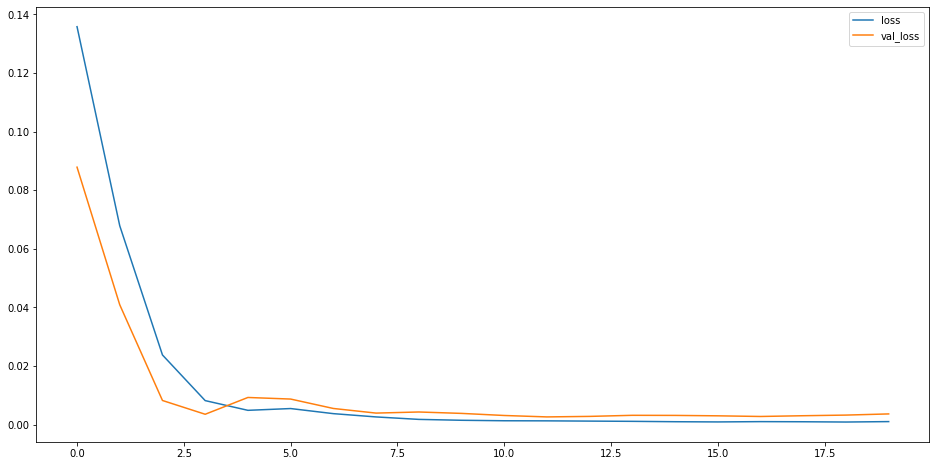

In [ ]:
plt.figure(figsize = (16,8))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [ ]:
PATH = "./drive/MyDrive/Machine_Learning/Mini-Project/LSTM_LB{}_FD{}_E{}_F{}_S{}.h5"
file_name = PATH.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `./drive/MyDrive/Machine_Learning/Mini-Project/LSTM_LB40_FD10_E20_F200_S100.h5` to disk


In [ ]:
X_test,y_test = processData(array_test,look_back,forward_days,num_companies,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

Xt = model.predict(X_test)
Xt.shape, Xt

((20, 50), array([[0.28140533, 0.25237247, 0.5908979 , 0.42598712, 0.17808841,
         0.26886818, 0.27231458, 0.63020635, 0.46085945, 0.20504585,
         0.22689533, 0.24245456, 0.6694906 , 0.43470606, 0.2568226 ,
         0.21350546, 0.20923084, 0.7022894 , 0.42277634, 0.24530162,
         0.21102744, 0.17351276, 0.6994484 , 0.45011303, 0.21454777,
         0.21037897, 0.19541681, 0.6671683 , 0.46023744, 0.18005745,
         0.17254736, 0.16126469, 0.65037787, 0.45458442, 0.15613958,
         0.18756172, 0.15511559, 0.6549449 , 0.43111548, 0.16510811,
         0.19963706, 0.17383881, 0.6741186 , 0.44167522, 0.1584776 ,
         0.21028481, 0.16903803, 0.64640456, 0.41687074, 0.14568943],
        [0.26547125, 0.24617931, 0.5706285 , 0.41578245, 0.16527049,
         0.26940945, 0.2681523 , 0.61708856, 0.45076072, 0.19584143,
         0.21863747, 0.22457555, 0.6400261 , 0.41886443, 0.24840078,
         0.2116326 , 0.2022164 , 0.6781339 , 0.3901692 , 0.23366983,
         0.20692   , 0.

In [ ]:
def do_inverse_transform(output_result,num_companies = 5):
    #From input/output nootbook: apply makeup, use scl.inverse_transform and remove makeup
    
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(norm.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [ ]:
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

In [ ]:
Xt = do_inverse_transform(Xt)

MP = prediction_by_step_by_company(Xt, num_companies)
MP.shape

(5, 20, 10)

In [ ]:
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [ ]:
Yt = do_inverse_transform(y_test)

MT = target_by_company(Yt, num_companies)
MT.shape

(5, 200)

In [ ]:
colors = ['r','g','c','m','y','r','g','c','m','y'] #from matplotlib
companies_names = stocks

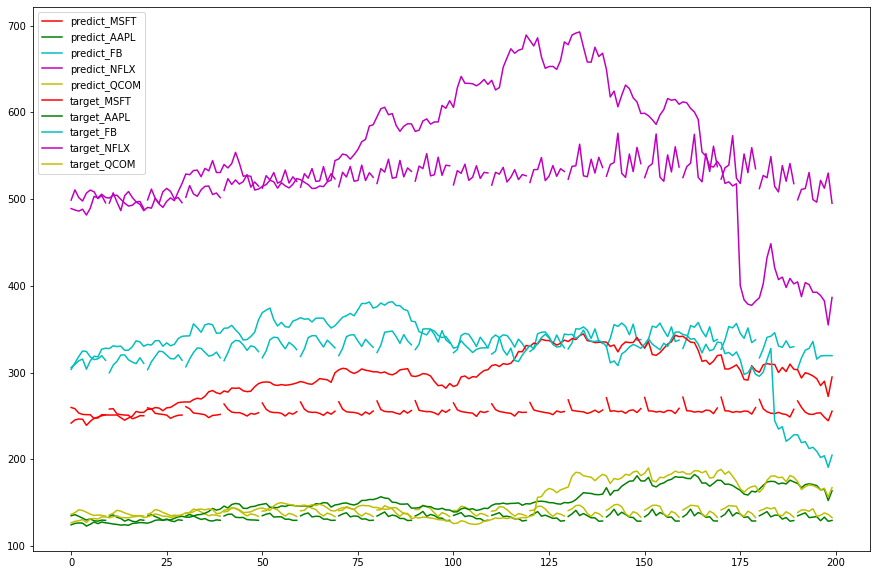

In [ ]:
plt.figure(figsize = (15,10))

companies_to_show = [0,1,2,3,4] #select one of [0,1,2,3] to see only one


    
for id_company in companies_to_show:
    for i in range(0,len(MP[id_company])):
        plt.plot([x + i*forward_days for x in range(len(MP[id_company][i]))], MP[id_company][i], color=colors[id_company])
    plt.plot(0,MP[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(MT[id_company],color=colors[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

In [ ]:
X_all,y_all = processData(array,look_back,forward_days,num_companies,forward_days)
y_all = np.array([list(a.ravel()) for a in y_all])

In [ ]:
Xt = model.predict(X_all)
Xt.shape

(21, 50)

In [ ]:
Xt = do_inverse_transform(Xt)

MP = prediction_by_step_by_company(Xt, num_companies)
MP.shape

(5, 21, 10)

In [ ]:
Yt = do_inverse_transform(y_all)

MT = target_by_company(Yt, num_companies)
MT.shape

(5, 210)

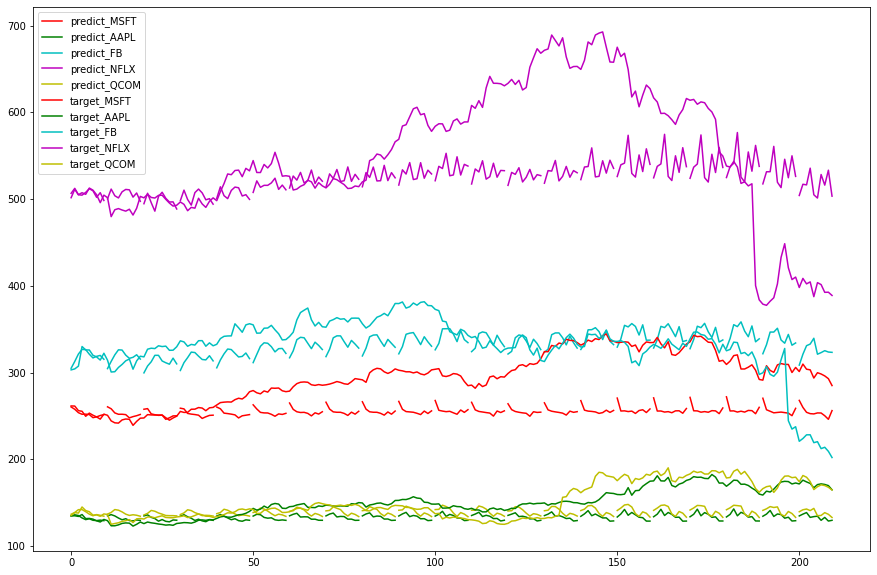

In [ ]:
plt.figure(figsize = (15,10))

companies_to_show = [0,1,2,3,4]#select one of [0,1,2,3] to see only one


    
for id_company in companies_to_show:
    for i in range(0,len(MP[id_company])):
        plt.plot([x + i*forward_days for x in range(len(MP[id_company][i]))], MP[id_company][i], color=colors[id_company])
    plt.plot(0,MP[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(MT[id_company], color=colors[id_company],label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

# Creating Seperate LSTMs for stable and volatile stocks

In [ ]:
stocks_stable = ['MSFT','FB','QCOM']
stocks_volatile = ['AAPL','NFLX']
num_companies_stable = 3
num_companies_volatile = 2

In [ ]:
from numpy.core.numeric import full

def create_lstm(stocks,num_companies):
  look_back = 20
  forward_days = 5
  num_periods = 80
  array =pd.DataFrame(columns = stocks)
  for stock in stocks:
    array[stock] = full_stock_df[stock+"_close"]
    #array[stock] = (array[stock] - array[stock].mean())/array[stock].std()

  array = array.values.tolist()
  array = norm.fit_transform(array)
  print(array)
  division = len(array) - num_periods*forward_days
  array_test = array[division-look_back:]
  array_train = array[:division]
  def processData(data, look_back, forward_days,num_companies,jump=1):
      X,Y = [],[]
      for i in range(0,len(data) -look_back -forward_days +1, jump):
          X.append(data[i:(i+look_back)])
          Y.append(data[(i+look_back):(i+look_back+forward_days)])
      return np.array(X),np.array(Y)

  X_test,y_test = processData(array_test,look_back,forward_days,num_companies,forward_days)
  y_test = np.array([list(a.ravel()) for a in y_test])

  X,y = processData(array_train,look_back,forward_days,num_companies)
  y = np.array([list(x.ravel()) for x in y])

  from sklearn.model_selection import train_test_split
  X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = False)

  NUM_NEURONS_FirstLayer = 200
  NUM_NEURONS_SecondLayer = 100
  EPOCHS = 20

  # #Build the model
  model = Sequential()
  model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,num_companies), return_sequences=True))
  # print(model.summary())
  model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
  # print(model.summary())
  model.add(Dense(forward_days * num_companies))
  # print(model.summary())
  model.compile(loss='mean_squared_error', optimizer='adam')
  print(model.summary())
  # verbose = [1 if EPOCHS%20 == 0 else 0]
  history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate), 
                      shuffle=True, batch_size=1, verbose=2)
  return model,history,X_test,y_test,look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer

In [ ]:
lstm_stable,history_stable,X_test_stable, y_test_stable, look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer = create_lstm(stocks_stable,num_companies_stable)

[[0.00559669 0.31030164 0.1307947 ]
 [0.         0.32200806 0.07269717]
 [0.04029619 0.35843406 0.10204696]
 [0.00447735 0.31030164 0.00316075]
 [0.05837782 0.36638353 0.09241421]
 [0.04727054 0.36186431 0.07344973]
 [0.08920269 0.41065011 0.13184828]
 [0.07663165 0.38108461 0.10535822]
 [0.06810746 0.40999673 0.13049368]
 [0.09290511 0.43928999 0.16119807]
 [0.08859997 0.46591528 0.16503612]
 [0.03289134 0.43613198 0.10189645]
 [0.025917   0.49880213 0.12251656]
 [0.07869812 0.51775019 0.16721854]
 [0.09152747 0.5016879  0.14373871]
 [0.07370415 0.45567897 0.06306442]
 [0.04666781 0.4371665  0.06547261]
 [0.08248665 0.46036154 0.15171583]
 [0.07206819 0.50332135 0.12492474]
 [0.0461512  0.48725907 0.10881999]
 [0.07766489 0.52373952 0.14494281]
 [0.13337351 0.54584558 0.22350993]
 [0.1908903  0.60143744 0.26189043]
 [0.18055795 0.58706305 0.2269717 ]
 [0.19795075 0.62452358 0.24789284]
 [0.22696745 0.62381575 0.2615894 ]
 [0.24909592 0.62082108 0.2653522 ]
 [0.25021526 0.61581183 0.21

KeyboardInterrupt: ignored

In [ ]:
lstm_volatile,history_volatile,X_test_volatile, y_test_volatile, look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer = create_lstm(stocks_volatile,num_companies_volatile)

In [ ]:
plt.figure(figsize = (16,8))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure(figsize = (16,8))

plt.plot(lstm_volatile.history['loss'], label='loss')
plt.plot(lstm_volatile.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [ ]:
PATH = "./drive/MyDrive/Machine_Learning/Mini-Project/LSTM_stable_{}_FD{}_E{}_F{}_S{}.h5"
file_name = PATH.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
lstm_stable.save(file_name)
print("Saved model `{}` to disk".format(file_name))

In [ ]:
PATH = "./drive/MyDrive/Machine_Learning/Mini-Project/LSTM_Volatile_{}_FD{}_E{}_F{}_S{}.h5"
file_name = PATH.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
lstm_volatile.save(file_name)
print("Saved model `{}` to disk".format(file_name))

In [ ]:
#X_test_stable,y_test_stable = processData(array_test_stable,look_back,forward_days,num_companies_stable,forward_days)
#y_test_stable = np.array([list(a.ravel()) for a in y_test_stable])

Xt_stable = lstm_stable.predict(X_test_stable)
Xt_stable.shape, Xt_stable

In [ ]:
Xt_volatile = lstm_volatile.predict(X_test_volatile)
Xt_volatile.shape, Xt_volatile

In [ ]:
def do_inverse_transform(output_result,num_companies):
    #From input/output nootbook: apply makeup, use scl.inverse_transform and remove makeup
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(norm.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    print(original_matrix_format)
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()
    print(original_matrix_format)
    return output_result

In [ ]:
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

In [ ]:
Xt_stable = do_inverse_transform(Xt_stable,num_companies_stable)

MP_stable = prediction_by_step_by_company(Xt_stable, num_companies_stable)
MP_stable.shape

In [ ]:
Xt_volatile = do_inverse_transform(Xt_volatile,num_companies_volatile)

MP_volatile = prediction_by_step_by_company(Xt_volatile, num_companies_volatile)
MP_volatile.shape

In [ ]:
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [ ]:
Yt_stable = do_inverse_transform(y_test_stable)

MT_stable = target_by_company(Yt_stable, num_companies_stable)
MT_stable.shape

In [ ]:
Yt_volatile = do_inverse_transform(y_test_volatile)

MT_volatile = target_by_company(Yt_volatile, num_companies_volatile)
MT_volatile.shape

In [ ]:
def plot_graph(stocks,i,MP,MT):
  colors = ['r','g','c','m','y'] #from matplotlib
  companies_names = stocks

  plt.figure(figsize = (15,10))

  temp = []
  if i+1 > 0 :
    temp.append(i)
    i = i-1

  temp = temp.reverse()
  companies_to_show = temp #select one of [0,1,2,3] to see only one


      
  for id_company in companies_to_show:
      for i in range(0,len(MP[id_company])):
          plt.plot([x + i*forward_days for x in range(len(MP[id_company][i]))], MP[id_company][i], color=colors[id_company])
      plt.plot(0,MP[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

    

  for id_company in companies_to_show:
      plt.plot(MT[id_company],color=colors[id_company], label='target_{}'.format(companies_names[id_company]))

  plt.legend(loc='best')
  plt.show()

In [ ]:
plot_graph(stocks_stable,3,MP_stable,MT_stable)

In [ ]:
plot_graph(stocks_volatile,3,MP_volatile,MT_volatile)

In [ ]:
X_all,y_all = processData(array,look_back,forward_days,num_companies,forward_days)
y_all = np.array([list(a.ravel()) for a in y_all])

In [ ]:
Xt = model.predict(X_all)
Xt.shape

In [ ]:
Xt = do_inverse_transform(Xt)

MP = prediction_by_step_by_company(Xt, num_companies)
MP.shape

In [ ]:
Yt = do_inverse_transform(y_all)

MT = target_by_company(Yt, num_companies)
MT.shape

In [ ]:
plt.figure(figsize = (15,10))

companies_to_show = [0,1,2,3,4]#select one of [0,1,2,3] to see only one


    
for id_company in companies_to_show:
    for i in range(0,len(MP[id_company])):
        plt.plot([x + i*forward_days for x in range(len(MP[id_company][i]))], MP[id_company][i], color=colors[id_company])
    plt.plot(0,MP[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(MT[id_company], color=colors[id_company],label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

In [ ]:
print(rest_api.get_clock())

# Backtrader - Using Library

In [ ]:
# import alpaca_backtrader_api
from alpaca_backtrader_api import *

Final Portfolio Value: 101228.70’


/usr/local/lib/python3.7/dist-packages/backtrader/plot/__init__.py:35: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornad

<Figure size 720x720 with 0 Axes>

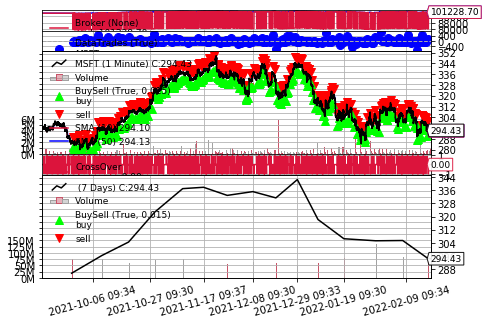

[[<Figure size 432x288 with 7 Axes>]]

In [ ]:
from datetime import datetime
# Create a subclass of Strategy to define the indicators and logic

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=50   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


cerebro = bt.Cerebro() 
# Create a data feed
# barset = rest_api.get_barset(stocks[0], 'day', limit= 150) 
# bars = barset[stocks[0]]
# data = [bars[index].c for index in range(len(bars))]
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents=20)
cerebro.addstrategy(SmaCross)  # Add the trading strategy

store = AlpacaStore(
    key_id=API_KEY_ID,
    secret_key=SECRET_KEY,
    paper=True
)

DataFactory = store.getdata

data0 = DataFactory(
    dataname='MSFT',
    timeframe=bt.TimeFrame.Minutes,
    fromdate=pd.Timestamp('2021-09-20'),
    todate=pd.Timestamp('2022-02-18'),
    historical=True)

cerebro.adddata(data0)
cerebro.resampledata(data0,compression=7, timeframe=bt.TimeFrame.Days)
cerebro.run()  # run it all
print('Final Portfolio Value: %.2f’'% cerebro.broker.getvalue())
fig = plt.figure(figsize = (10,10))
cerebro.plot()  # and plot it with a single command

### SMA Crossover = final value 101228.70, profit = 1228.70


Final Portfolio Value: 101064.85’


/usr/local/lib/python3.7/dist-packages/backtrader/plot/plot.py:127: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/p

<Figure size 720x720 with 0 Axes>

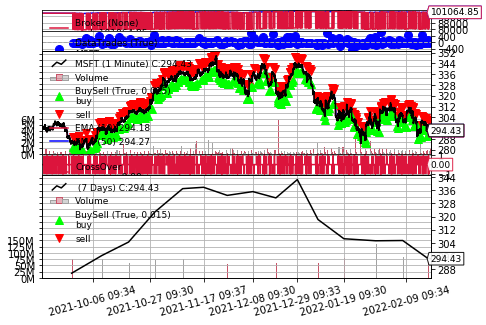

[[<Figure size 432x288 with 7 Axes>]]

In [ ]:
from datetime import datetime
# Create a subclass of Strategy to define the indicators and logic

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=50   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.EMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.EMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


cerebro = bt.Cerebro() 
# Create a data feed
# barset = rest_api.get_barset(stocks[0], 'day', limit= 150) 
# bars = barset[stocks[0]]
# data = [bars[index].c for index in range(len(bars))]
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents=20)
cerebro.addstrategy(SmaCross)  # Add the trading strategy

store = AlpacaStore(
    key_id=API_KEY_ID,
    secret_key=SECRET_KEY,
    paper=True
)

DataFactory = store.getdata

data0 = DataFactory(
    dataname='MSFT',
    timeframe=bt.TimeFrame.Minutes,
    fromdate=pd.Timestamp('2021-09-20'),
    todate=pd.Timestamp('2022-02-18'),
    historical=True)

cerebro.adddata(data0)
cerebro.resampledata(data0,compression=7, timeframe=bt.TimeFrame.Days)
cerebro.run()  # run it all
print('Final Portfolio Value: %.2f’'% cerebro.broker.getvalue())
fig = plt.figure(figsize = (10,10))
cerebro.plot()  # and plot it with a single command

### EMA Crossover = final value 101064.85, profit = 1064.85

# Scammer's win 

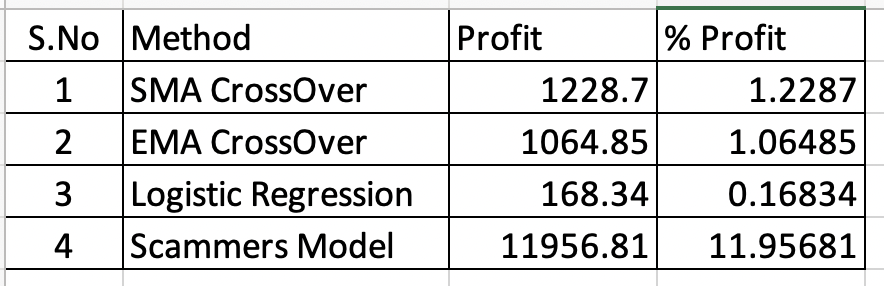

#Question11:
Another performance metric through backtesting could be:
1. False Positive (BUY)
2. False Negative (SELL)
3. Profit distribution in the timeframe 
4. Identifying buy trough and Sell peaks. 


# Question 12 : Take-aways 
1. Developed Machine Learning modelling patience
2. Finding Buy-Sell Strategy is tough. We explored financial literature to understand money and the trading behaviours. 

## SMA, EMA 
- SMA gives equal weightage to all data points in the series.
- In EMA, recent data gets the max weightage over the oldest.
-	When the faster SMA is above, the slower SMA we will issue a buy order. The trade will continue until the faster SMA falls below, the slower SMA which is when we sell.
- The longer the time frame for a crossover system, the lesser the trading signals.

## STL
- STL give great insights on seasonality and trends. 
- Seasonality information can be used to make profitable trades in long term. 
- We can also use the residual to detect anomaly in the data. These anomaly can be used to validate the trading signals. However, due to time contrainst we didn't pursued this. 


### Logistics Regression
- We also tried training our model with multinomial logistic regression model. The model was able to generate the signal but it outcomes where not satifactory. 
- Each vector in Logistic regression model consist of close, open, high and low prices. 

### LSTM
- We also implemented LSTM to predict prices for the next 10 days considering 40 days of lookback.
- Initially we created 1 LSTM which trained
on all the 5 stocks. As we specifically chose a equal distribution of stable and volatile stocks , the LSTM learnt both the movements. 
- When we tested the prediction curves at regular intervals, we observed less than satisfactory predictions for the volatile stocks esp. near
the abnormal dips and peaks.
- Hence we decided to create 2 LSTMs, one for stable stocks and the other for volatile ones. 
- We did see better results for the volatile stocks but in the end we didnt incorporate it in the final buy/sell strategy using MFM. If we had time to spare we would validate MFM signals with LSTM price predictions to include advantage of memory that comes with LSTMs.

## Scammer's Model - Modified Money Flow Multiplier 
We tested multiple strategies which were able to generate profits but they were not able to generate frequent trading signals. One possible reason could be data points that were considered i.e., SMA and EMA considered only one price, opening or closing. So, we moved forward with combining other prices. 

- Money flow multiplier considers different prices like closing, high and low. 
- as it is considering mutliple parameters, it is expected to give better results and this hypothesis was validated during backtrading. 
- Money flow indicator gave frequent and more correct signals. However, We considered only buy signals for trading with custom selling strategy. 

- The scammer's model is the modified money flow indicator which is especially redesigned to make profits. 
- At each buy we bought but we sold if we received a defined profit. 


# Work distribution
Mayank: SMA, EMA, plotting, Logistic regressor and Money Flow Multiplier.

Rishabh: STL, Buy/Sell Strategy, backtrader using Alpaca, LSTMs 

**Common:**  Scammer's Strategy, Backtrading custom class

We both held rigorous discussions on developing current and future improvements to buy/sell strategy. We also maintained version history for any major milestones and releases.